# Unveiling Economic Disparities in the United States: A Visual Analysis of IPUMS USA Data (2006-2021)

#### Xixuan Li

Within this data visualisation notebook, the analysis delves into US wealth disparities utilizing IPUMS USA data spanning 2006 to 2021 (excluding 2020 due to the pandemic). IPUMS USA, the Integrated Public Use Microdata Series, offers an invaluable collection of U.S. Census and American Community Survey (ACS) data. The Census, conducted once every decade, compels nearly everyone to participate, yielding a comprehensive snapshot of the population's characteristics. In contrast, ACS is a yearly survey that captures data from approximately 1% of the population annually. However, the custom density comprises approximately 0.5% of what the ACS offers, emphasizing that the visualization isn't strictly representative of the ACS due to the smaller sample size. The dataset used in this study contains 421,998 rows, showcasing a remarkable equilibrium in the distribution of rows across different years. For detailed year-specific figures, please refer to the accompanying graph. This notebook will explore economic inequality involving race, gender, and education. The goal is to synthesise economic patterns into comprehensible visuals, providing insights into the multifaceted variables influencing wealth disparities.


In [1]:
# Import the relevant libraries
import numpy as np
import pandas as pd
import matplotlib as plt
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objs as po
import plotly.graph_objs as go
import plotly as py
%matplotlib inline
import random
import plotly.subplots as sp
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs,init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
#Data Preprocessing
df = pd.read_csv('usa_00017.csv')
df["RACHSING"].replace({1: "White", 2: "Black/African American", 3:"American Indian/Alaska Native", 4:"Asian/Pacific Islander", 5:"Hispanic/Latino"}, inplace=True)

def preprocess_data(df):
    education_mapping = {
        0: None,  # Drop rows with value 0
        1: "Less than a High School Diploma",
        2: "Less than a High School Diploma",
        3: "Less than a High School Diploma",
        4: "Less than a High School Diploma",
        5: "High School Diploma",
        6: "High School Diploma",
        7: "Some College, No Degree",
        8: "Some College, No Degree",
        9: "Some College, No Degree",
        10: "Bachelor's Degree",
        11: "More than 5 Years of College"
    }

    # Drop rows with value 0 and update other values based on mapping
    df['EDUC'] = df['EDUC'].map(education_mapping).dropna()

    return df

# Preprocess the original DataFrame
df = preprocess_data(df)

In [3]:
#Data Adjustment for Income Analysis
adjustment_factors = {
    2006: 0.826, 2007: 0.804, 2008: 0.774, 2009: 0.777, 2010: 0.764,
    2011: 0.741, 2012: 0.726, 2013: 0.715, 2014: 0.704, 2015: 0.703,
    2016: 0.694, 2017: 0.679, 2018: 0.663, 2019: 0.652, 2020: 0.644, 2021: 0.615
}

# Adjust values of both INCTOT and FTOTINC columns based on the adjustment factors
for year, factor in adjustment_factors.items():
    df.loc[df['YEAR'] == year, ['INCTOT', 'FTOTINC']] *= factor

In [4]:
#Data Cleaning
df2 = df.drop(df[df['COSTELEC'] < 1].index)
dfFinal = df2.drop(df2[(df2['COSTELEC'] > 9992) | (df2['VALUEH']> 9999997) | (df2['VALUEH'] < 1) | (df2['TRANTIME'] < 1) | (df2['COSTGAS'] < 1) | (df2['COSTWATR'] < 1)
                   | (df2['COSTWATR'] > 9992) | (df2['COSTGAS'] > 9992) | (df2['INCTOT'] == 9999999) | (df2['INCTOT'] < 0)| (df2['FTOTINC'] < 1)| (df2['FTOTINC'] > 9999997 )|(df2['OWNERSHP'] == 0)].index)
                       
dfFinal["REGION"].replace({11:"New England Division",12: "Middle Atlantic Division",21: "East North Central Division", 22: "West North Central Division",
                     31: "South Atlantic Division", 32: "East South Central Division", 33:"West South Central Division", 
                      41: "Mountain Division", 42: "Pacific Division"}, inplace=True)
data_R = {'NORTHEAST REGION': ['New England Division', 'Middle Atlantic Division',"NA"],
        'MIDWEST REGION': ['East North Central Division','West North Central Division',"NA"],
        'SOUTH REGION': ['South Atlantic Division', 'East South Central Division','West South Central Division'], 
          'WEST REGION': ['Mountain Division', 'Pacific Division',"NA"]}

dfFinal["Macro_region"] = dfFinal["REGION"]

replace_dict = {}
for macro_region, components in data_R.items():
    for component in components:
        if component == "NA": continue
        
        replace_dict[component] = macro_region
dfFinal = dfFinal.replace({"Macro_region" : replace_dict})
dfFinal["SEX"].replace({1: "Male", 2: "Female"}, inplace=True)
dfFinal["SPMPOV"].replace({0: "Not in Poverty", 1: "In Poverty"}, inplace=True)
dfFinal["FOODSTMP"].replace({1: "Without Assistance", 2: "With Assistance"}, inplace=True)
dfFinal["RACHSING"].replace({1: "White", 2: "Black/African American", 3:"American Indian/Alaska Native",
                             4:"Asian/Pacific Islander", 5:"Hispanic/Latino"}, inplace=True)
categories = ['Bottom 0.1%', 'Bottom 1%', 'Bottom 10%', 'Top 10%', 'Top 1%', 'Top 0.1%']
percentiles = [0.001, 0.01, 0.1, 0.9, 0.99, 0.999]
quantiles = dfFinal['INCTOT'].quantile(percentiles)
dfFinal['Income Category'] = dfFinal['INCTOT'].apply(lambda x: next((
    categories[i] for i, q in enumerate(quantiles) if x <= q), categories[-1])
)

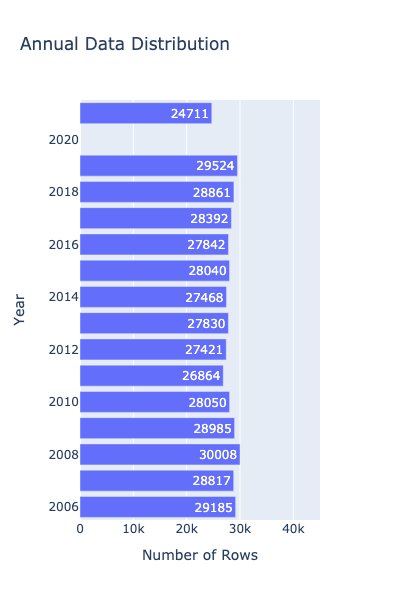

In [6]:
#Yearly Data Distribution and Total Rows
year_counts = dfFinal['YEAR'].value_counts().reset_index()
year_counts.columns = ['Year', 'Count']

total_rows = len(dfFinal)

total_row_df = pd.DataFrame({'Year': ['Total Rows'], 'Count': [total_rows]})

year_counts = pd.concat([year_counts, total_row_df], ignore_index=True)

total_all_years_df = pd.DataFrame({'Year': ['Total All Years'], 'Count': [total_rows]})

year_counts_with_total = pd.concat([year_counts, total_all_years_df], ignore_index=True)

fig = px.bar(year_counts_with_total, x='Count', y='Year', orientation='h',
             title='Annual Data Distribution',
             labels={'Count': 'Number of Rows'})

fig.update_traces(text=year_counts_with_total['Count'], textposition='inside')

fig.update_layout(width=400, height=600)

fig.update_xaxes(range=[0, 45000])

fig.show(renders="svg")

## General Wealth Disparities Graphs

### Top 100 Richest vs Bottom 5000 Poorest Earners

This visualization captures the stark income divide by analysing the combined income of the top 100 wealthiest earners versus the bottom 5000 earners over time. While 50 times more individuals are in the latter group, the top 100 earners collectively possess nearly 25% more income than the bottom 5000 earners.

For a decade, the income gap shows little sign of narrowing, emphasizing persistent inequality. Notably, around 2012, the top earners' cumulative income experienced a subtle rise. Meanwhile, the bottom 5000 earners' combined income remains relatively stable, potentially intensifying the income gap.

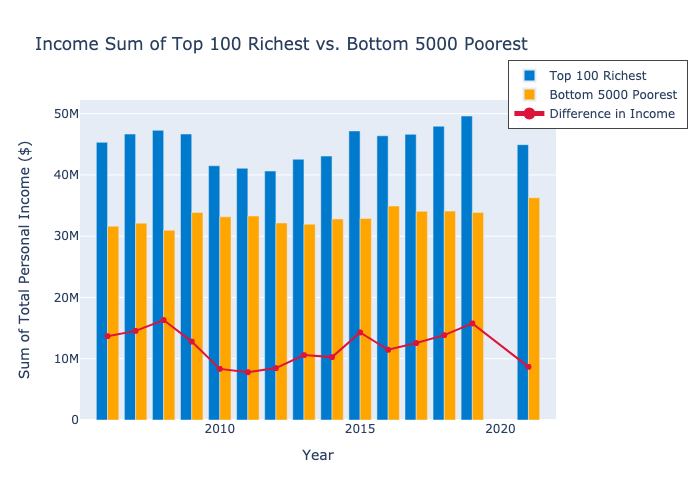

In [7]:
#Economic Disparity
top_100_richest = dfFinal.groupby('YEAR')['INCTOT'].nlargest(100).groupby('YEAR').sum()


bottom_100_poorest = dfFinal.groupby('YEAR')['INCTOT'].nsmallest(5000).groupby('YEAR').sum()


difference = top_100_richest - bottom_100_poorest


fig = make_subplots(rows=1, cols=1, shared_xaxes=True)


fig.add_trace(go.Bar(x=top_100_richest.index, y=top_100_richest.values,
                     name='Top 100 Richest', marker_color='#007ACC'),
              row=1, col=1)

fig.add_trace(go.Bar(x=bottom_100_poorest.index, y=bottom_100_poorest.values,
                     name='Bottom 5000 Poorest ', marker_color='orange'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=difference.index, y=difference.values,
                         name='Difference in Income', mode='lines+markers', line_color='#DC143C'),
              row=1, col=1)


fig.update_layout(
    title='Income Sum of Top 100 Richest vs. Bottom 5000 Poorest',
    xaxis_title='Year',
    yaxis_title='Sum of Total Personal Income ($)',
    legend=dict(x=0.9, y=1.125,borderwidth=1, itemsizing='constant'),font=dict(size=12),
    height=500
)

fig.show()

### Personal and Family Income 


This analysis explores income distribution across personal and family earnings in various percentiles. The gap between those in the 10th percentile and those in the 50th percentile is considerably smaller than the disparity between those in the 50th percentile and those in the 90th percentile. Regarding personal income, the only group that observes a slight increase in revenue is the 90th percentile, as the rest seems "unchanged." In contrast, family income follows a different trend from personal income across the three percentiles, showing a different trajectory. Family income for the top earners continues to rise, while lower percentiles remain stable. This divergence is attributed to the complexity of family income sources. The contrast underscores the role of family dynamics in shaping income disparities. The comparison provides insights into potential personal and household financial well-being trends over time, with personal incomes declining but family incomes showing a more modest increase. This suggests changing family dynamics or socioeconomic shifts impact household stability differently than individual income trends.


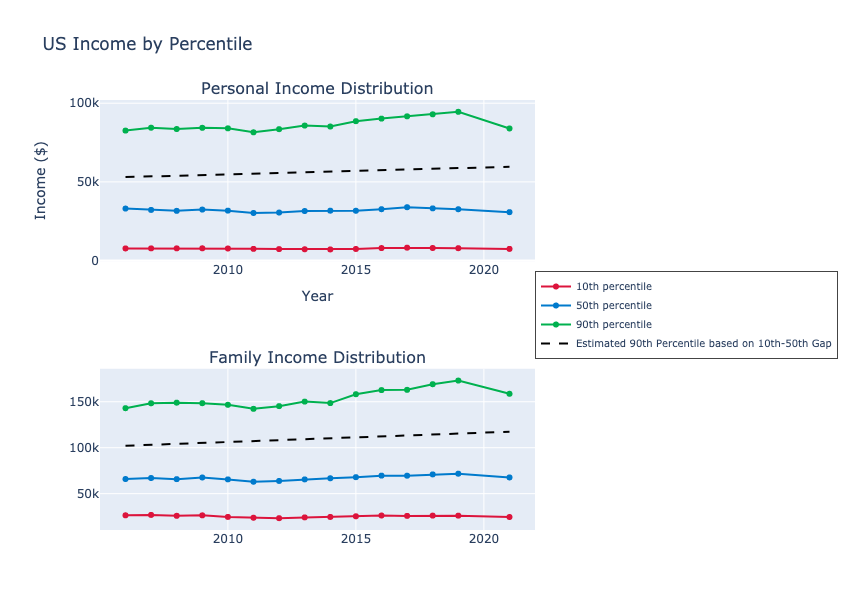

In [8]:
# Calculate percentiles for Personal Income
tenPe = dfFinal.groupby(["YEAR"], as_index=False)['INCTOT'].quantile(0.1)
fiftyPe = dfFinal.groupby(["YEAR"], as_index=False)['INCTOT'].quantile(0.5)
ninetyPe = dfFinal.groupby(["YEAR"], as_index=False)['INCTOT'].quantile(0.9)
difference_Pe = fiftyPe['INCTOT'] - tenPe['INCTOT']
ninetyP_calculated_Pe = fiftyPe['INCTOT'] + difference_Pe

# Calculate percentiles for Family Income
tenP = dfFinal.groupby(["YEAR"], as_index=False)['FTOTINC'].quantile(0.1)
fiftyP = dfFinal.groupby(["YEAR"], as_index=False)['FTOTINC'].quantile(0.5)
ninetyP = dfFinal.groupby(["YEAR"], as_index=False)['FTOTINC'].quantile(0.9)
difference = fiftyP['FTOTINC'] - tenP['FTOTINC']
ninetyP_calculated = fiftyP['FTOTINC'] + difference

# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=("Personal Income Distribution",
                                                     "Family Income Distribution"))

# Add traces for Personal Income percentiles
fig.add_trace(go.Scatter(x=tenPe['YEAR'], y=tenPe['INCTOT'], mode='lines+markers', line=dict(color='#DC143C'), name='10th percentile'), row=1, col=1)
fig.add_trace(go.Scatter(x=fiftyPe['YEAR'], y=fiftyPe['INCTOT'], mode='lines+markers', line=dict(color='#007ACC'), name='50th percentile'), row=1, col=1)
fig.add_trace(go.Scatter(x=ninetyPe['YEAR'], y=ninetyPe['INCTOT'], mode='lines+markers', line=dict(color='#00B14F'), name='90th percentile', showlegend=True), row=1, col=1)
fig.add_shape(type='line', x0=min(ninetyPe['YEAR']), x1=max(ninetyPe['YEAR']), y0=ninetyP_calculated_Pe.min(), y1=ninetyP_calculated_Pe.max(), line=dict(color='black', dash='dash'), row=1, col=1)

# Add traces for Family Income percentiles
fig.add_trace(go.Scatter(x=tenP['YEAR'], y=tenP['FTOTINC'], mode='lines+markers', line=dict(color='#DC143C'), name='10th percentile',showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=fiftyP['YEAR'], y=fiftyP['FTOTINC'], mode='lines+markers', line=dict(color='#007ACC'), name='50th percentile', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=ninetyP['YEAR'], y=ninetyP['FTOTINC'], mode='lines+markers', line=dict(color='#00B14F'), name='90th percentile', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=[min(ninetyP['YEAR']), max(ninetyP['YEAR'])], y=[ninetyP_calculated.min(), ninetyP_calculated.max()], mode='lines', line=dict(color='black', dash='dash'), name='Estimated 90th Percentile based on 10th-50th Gap'), row=2, col=1)

# Update layout for the entire figure
fig.update_layout(
    height=600,width = 850,
    title_text='US Income by Percentile',
    xaxis_title='Year',
    yaxis_title='Income ($)',
    legend=dict(x=1, y=0.5, font_size=10,borderwidth=1),
    margin=dict(l=100, r=20, t=100, b=70)
)
\
fig.show()

### Income Allocation Shifts

Examining income distribution across two time periods—1960 to 1980 and 2006 to 2021—we classify earners into three groups: bottom 50%, middle 50-90%, and top 10%. Over two decades, the top 10% and middle 50%-90% of 1980 saw a 3% income share decrease, while the bottom 50% doubled their share. From 2006 to 2021, the top 10% gained over 2%, the middle group rose 0.6%, and the bottom 50% dropped by 2%.

 Recent trends exacerbate economic disparities, with the rich getting richer and the less fortunate losing ground. A closer numerical look reveals that the bottom earners' income increased mainly due to a 10% decrease in the middle group's share from 1980 to 2021. The top 10% remained nearly unchanged over 40 years, emphasizing wealth concentration, and highlighting the need to address inequality and promote equitable economic progress.

In [ ]:
df_old = pd.read_csv('usa_00019.csv')
dfFinal2 = df_old.drop(df_old[(df_old['INCTOT'] == 9999999) | (df_old['INCTOT'] < 0)| (df2['OWNERSHP'] == 0)].index)

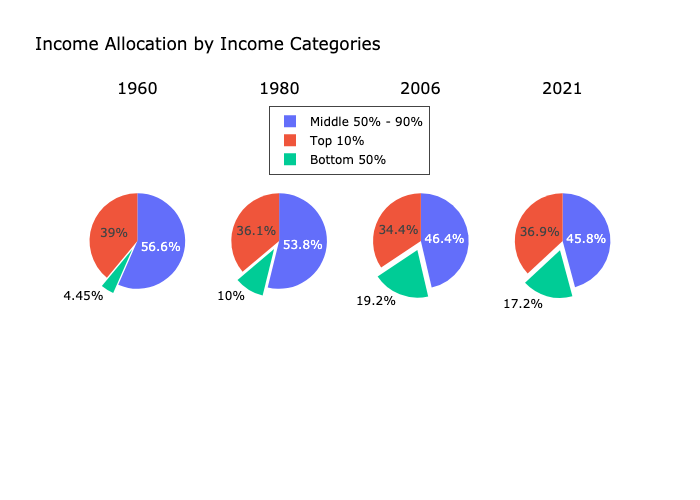

In [10]:
# Year 1960
YearS_1960 = dfFinal2.query("YEAR == 1960")
bottom_50_percentile_1960 = YearS_1960['INCTOT'].quantile(0.5)
bottom_50_1960 = YearS_1960[YearS_1960['INCTOT'] < bottom_50_percentile_1960]
top_10_percentile_1960 = YearS_1960['INCTOT'].quantile(0.9)
top_10_1960 = YearS_1960[YearS_1960['INCTOT'] > top_10_percentile_1960]
middle_50_to_90_1960 = YearS_1960[(YearS_1960['INCTOT'] >= bottom_50_percentile_1960) & (YearS_1960['INCTOT'] <= top_10_percentile_1960)]
bottom_1960 = bottom_50_1960['INCTOT'].sum()
top_10_1960 = top_10_1960['INCTOT'].sum()
middle_50_to_90_1960 = middle_50_to_90_1960['INCTOT'].sum()
data = {
    "Percentile_Category": ["Bottom 50% of income earners ", "Middle 50% - 90% of income earners", "Top 10% of income earners"],
    "Total_Income": [7177150, 91192650, 62861450]
}

data1960 = pd.DataFrame(data)
total_income_1960 = data1960["Total_Income"].sum()
data1960["Income_Percentage"] = (data1960["Total_Income"] / total_income_1960) * 100


# Year 1980
YearS_1980 = dfFinal2.query("YEAR == 1980")
bottom_50_percentile_1980 = YearS_1980['INCTOT'].quantile(0.5)
bottom_50_1980 = YearS_1980[YearS_1980['INCTOT'] < bottom_50_percentile_1980]
top_10_percentile_1980 = YearS_1980['INCTOT'].quantile(0.9)
top_10_1980 = YearS_1980[YearS_1980['INCTOT'] > top_10_percentile_1980]
middle_50_to_90_1980 = YearS_1980[(YearS_1980['INCTOT'] >= bottom_50_percentile_1980) & (YearS_1980['INCTOT'] <= top_10_percentile_1980)]
bottom_1980 = bottom_50_1980['INCTOT'].sum()
top_10_1980 = top_10_1980['INCTOT'].sum()
middle_50_to_90_1980 = middle_50_to_90_1980['INCTOT'].sum()

data_1980 = {
    "Percentile_Category": ["Bottom 50% of income earners", "Middle 50% - 90% of income earners", "Top 10% of income earners"],
    "Total_Income": [161485270,868569755,583100420]
}

data1980_df = pd.DataFrame(data_1980)
total_income_1980 = data1980_df["Total_Income"].sum()
data1980_df["Income_Percentage"] = (data1980_df["Total_Income"] / total_income_1980) * 100

#year 2006
YearS = dfFinal.query("YEAR == 2006")
bottom_50_percentile = YearS['INCTOT'].quantile(0.5)
bottom_50 = YearS[YearS['INCTOT'] < bottom_50_percentile]
top_10_percentile = YearS['INCTOT'].quantile(0.9)
top_10 = YearS[YearS['INCTOT'] > top_10_percentile]
middle_50_to_90 = YearS[(YearS['INCTOT'] >= bottom_50_percentile) & (YearS['INCTOT'] <= top_10_percentile)]
bottom_2006 = bottom_50['INCTOT'].sum()
top_10_2006 = top_10['INCTOT'].sum()
middle_50_to_90_2006 = middle_50_to_90['INCTOT'].sum()
data = {
    "Percentile_Category": ["Bottom 50% of income earners ", "Middle 50% - 90% of income earners", "Top 10% of income earners"],
    "Total_Income": [298620320, 719582761, 719582761]
}

data2006 = pd.DataFrame(data)
total_income_2006 = data2006["Total_Income"].sum()
data2006["Income_Percentage"] = (data2006["Total_Income"] / total_income_2006) * 100

#year 2021

YearT = dfFinal.query("YEAR == 2021")
bottom_50_percentile2 = YearT['INCTOT'].quantile(0.5)
bottom_50_2 = YearT[YearT['INCTOT'] < bottom_50_percentile2]
top_10_percentile2 = YearT['INCTOT'].quantile(0.9)
top_10_2 = YearT[YearT['INCTOT'] > top_10_percentile2]
middle_50_to_90_2 = YearT[(YearT['INCTOT'] >= bottom_50_percentile2) & (YearT['INCTOT'] <= top_10_percentile2)]
bottom_2021 = bottom_50_2['INCTOT'].sum()
top_10_2021 = top_10_2['INCTOT'].sum()
middle_50_to_90_2021 = middle_50_to_90_2['INCTOT'].sum()
data = {
    "Percentile_Category": ["Bottom 50% of income earners ", "Middle 50% - 90% of income earners", "Top 10% of income earners"],
    "Total_Income": [306444751, 814962076, 657178880]
}

data2021 = pd.DataFrame(data)
total_income_2021 = data2021["Total_Income"].sum()
data2021["Income_Percentage"] = (data2021["Total_Income"] / total_income_2021) * 100

fig = go.Figure()

labels = ["Bottom 50%", "Middle 50% - 90%", "Top 10%"]

fig = make_subplots(1, 4, specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]],
                    subplot_titles=['1960', '1980','2006', '2021'])
fig.add_trace(go.Pie(labels=labels, values=[7177150*4.540, 91192650*4.540, 62861450*4.540], scalegroup='one',
                     name="Percentage of Income by Percentile Category in 1960",pull=[0.2, 0, 0]), 1, 1)
fig.add_trace(go.Pie(labels=labels, values=[161485270*2.295,868569755*2.295,583100420*2.295], scalegroup='two',
                     name="Percentage of Income by Percentile Category in 1980",pull=[0.2, 0, 0]), 1, 2)

fig.add_trace(go.Pie(labels=labels, values=[298620320*0.826, 719582761*0.826, 533740302*0.826], scalegroup='three',
                     name="Percentage of Income by Percentile Category in 2006",pull=[0.2, 0, 0]), 1, 3)
fig.add_trace(go.Pie(labels=labels, values=[306444751*0.615, 814962076*0.615, 657178880*0.615], scalegroup='four',
                     name="Percentage of Income by Percentile Category in 2021",pull=[0.2, 0, 0]), 1, 4)
fig.update_layout(height = 500,
    title_text='Income Allocation by Income Categories',
    font=dict(color='black'),
    showlegend=True,
    legend=dict(x=0.35, y=0.98,borderwidth=1, itemsizing='constant'),
)
fig.show()

### Income Share by Income Categories and Year Group

The analysis reveals an increase in wealth accumulation for the top 10% within individual and family income categories from 2014 to 2021, while the broader groups experienced declining income shares. Family income data shows that the top 10% and second top 10% percentiles have gained income share over time, possibly due to wealth accumulation and policies favouring higher-income families. These opposing trends emphasise the intricate nature of disparities. 


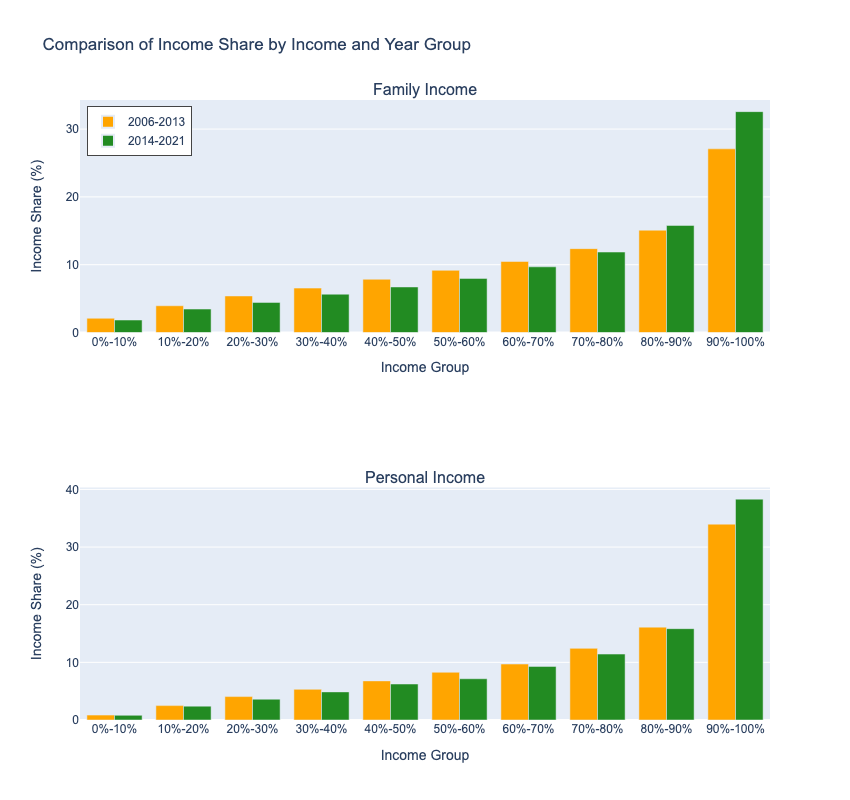

In [11]:
orange_color = 'orange'
green_color = '#228B22'

# Create filtered dataframes
dfFilterFamily = dfFinal[(dfFinal['YEAR'] >= 2006) & (dfFinal['YEAR'] <= 2021)]
dfFilterIncome = dfFinal[(dfFinal['YEAR'] >= 2006) & (dfFinal['YEAR'] <= 2021)]

# Create bins and labels for income percentiles
income_percentiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']

# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=("Family Income", "Personal Income"))

# Iterate over each filtered dataframe
for idx, dfFilter in enumerate([dfFilterFamily, dfFilterIncome]):

    # Determine column name based on index
    column_name = 'FTOTINC' if idx == 0 else 'INCTOT'

    # Create a new column to categorize income percentiles
    dfFilter['Income Percentile'] = pd.cut(dfFilter[column_name], bins=dfFilter[column_name].quantile(income_percentiles),
                                           labels=bin_labels, include_lowest=True)

    # Calculate the sum of income for each year
    total_income_per_year = dfFilter.groupby('YEAR')[column_name].sum().reset_index()

    # Group data by income percentile and year group
    dfFilter['Year Group'] = dfFilter['YEAR'].apply(lambda x: '2006-2013' if x <= 2013 else '2014-2021')

    # Calculate the sum of income for each percentile category and year group
    income_per_percentile_group = dfFilter.groupby(['Income Percentile', 'Year Group'])[column_name].sum().reset_index()

    # Calculate the sum of income for each year and year group
    total_income_per_year_group = income_per_percentile_group.groupby('Year Group')[column_name].sum().reset_index()

    # Merge the total_income_per_year_group with income_per_percentile_group
    income_per_percentile_group = pd.merge(income_per_percentile_group, total_income_per_year_group, on='Year Group', suffixes=('', '_total'))

    # Calculate the income share percentage
    income_per_percentile_group['Income Share'] = (income_per_percentile_group[column_name] / income_per_percentile_group[column_name + '_total']) * 100

    # Add bar traces for each case
    for col in income_per_percentile_group['Year Group'].unique():
        filtered_data = income_per_percentile_group[income_per_percentile_group['Year Group'] == col]
        color = orange_color if col == '2006-2013' else green_color
        fig.add_trace(go.Bar(x=filtered_data['Income Percentile'], y=filtered_data['Income Share'], name=col, marker=dict(color=color)), row=idx + 1, col=1)

# Update layout and style
for row in [1, 2]:
    fig.update_xaxes(title_text=("Income Group" if row == 1 else "Income Group"), showgrid=False, categoryorder='array', categoryarray=bin_labels, row=row, col=1)
    fig.update_yaxes(title_text="Income Share (%)", showgrid=True, row=row, col=1)

fig.update_layout(
    showlegend=True,
    font=dict(family='Arial, sans-serif', size=12),
    legend=dict(x=0.01, y=0.99,borderwidth=1, itemsizing='constant'),
    barmode='group', 
    title_text="Comparison of Income Share by Income and Year Group",
    height=800, width = 850
)

fig.update_traces(showlegend=True, row=1, col=1)
fig.update_traces(showlegend=False, row=2, col=1)

fig.show()


### Number of Individuals Across Income Percentiles Required to Reach 1 Million Dollars
The graph illustrates the number of individuals needed in different income percentiles to accumulate 1 million dollars. Across all macroregions, individuals in the 90th percentile require the fewest people (around 10) to reach this milestone. Those in the 50th percentile need roughly three times as many people. However, individuals in the 10th percentile face a significant challenge, needing more than ten times the number of individuals (about 130) compared to the 90th percentile to amass 1 million dollars. This graph highlights the growing income inequality within these macroregions, emphasizing the disparities in wealth distribution.

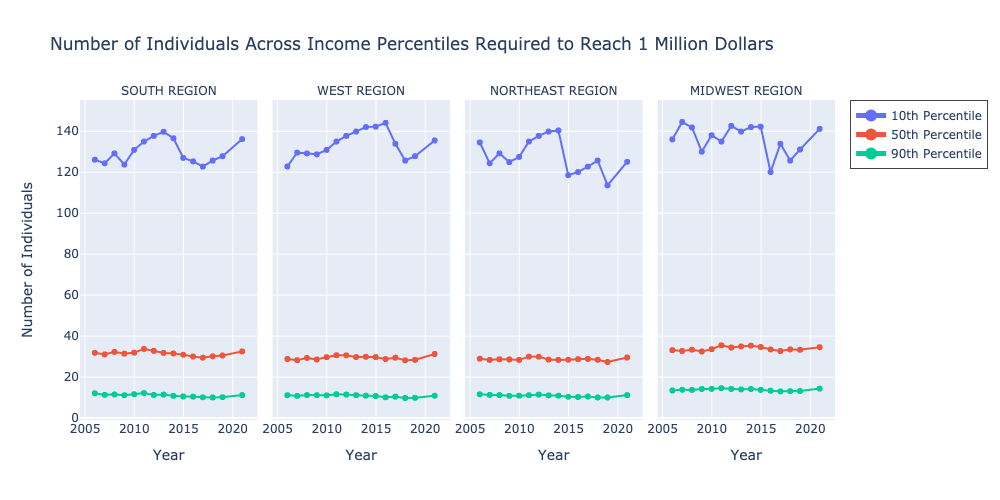

In [12]:
regions = dfFinal['Macro_region'].unique()
grouped_dfs = []

for region in regions:
    region_df = dfFinal[dfFinal['Macro_region'] == region]
    income_percentiles = region_df.groupby('YEAR')['INCTOT'].quantile([0.1, 0.5, 0.9]).unstack()
    income_percentiles.columns = ['0.1_percentile', '0.5_percentile', '0.9_percentile']
    region_df = region_df.merge(income_percentiles, on='YEAR')
    region_df['Times_10th'] = 1000000 / region_df['0.1_percentile']
    region_df['Times_50th'] = 1000000 / region_df['0.5_percentile']
    region_df['Times_90th'] = 1000000 / region_df['0.9_percentile']
    grouped_dfs.append(region_df)

final_df = pd.concat(grouped_dfs)

# Create a line chart using Plotly Express with subplots by Macro_region
fig = px.line(final_df, x='YEAR', y=['Times_10th', 'Times_50th', 'Times_90th'],
              title='Number of Individuals Across Income Percentiles Required to Reach 1 Million Dollars',
              labels={'YEAR': 'Year', 'value': 'Number of Times'},
              facet_col='Macro_region')

# Add markers for the data points
fig.update_traces(mode='lines+markers')

# Set hover text to display the y-axis values
for col in ['Times_10th', 'Times_50th', 'Times_90th']:
    for trace in fig.data:
        trace.hovertext = final_df[col].astype(int).astype(str)

# Update legend names
for trace in fig.data:
    if trace.name in ['Times_10th', 'Times_50th', 'Times_90th']:
        trace.name = trace.name.replace('Times_10th', '10th Percentile').replace('Times_50th', '50th Percentile').replace('Times_90th', '90th Percentile')

# Update layout for facet column labels
fig.update_layout(width = 1000, xaxis_title="Year", yaxis_title="Number of Individuals", legend =dict(borderwidth=1, itemsizing='constant'))

# Update facet column labels
facet_col_names = final_df['Macro_region'].unique()
for i, col_name in enumerate(facet_col_names):
    fig.layout.annotations[i]['text'] = col_name
fig.update_layout(legend_title_text='')
fig.show()

### Personal Income Trend

Across macro-regions, while average personal income displays an upward trajectory, the 10th percentile remains unaltered across regions, revealing a consistent challenge for this income segment. In contrast, the 90th percentile exhibits varying changes depending on the region, reflecting regional economic dynamics. This divergence underscores economic disparities and their regional dimensions, providing insights into wealth concentration. The analysis unveils the interplay of economic factors and geographic location in shaping income distribution's regional nuances. For an interactive creative visualization of this data, you can find a link just below. 


[Personal Income Trend](https://htmlpreview.github.io/?https://github.com/Lixx05/Economic.Inequality/blob/main/Personal_Income_Trend.html)

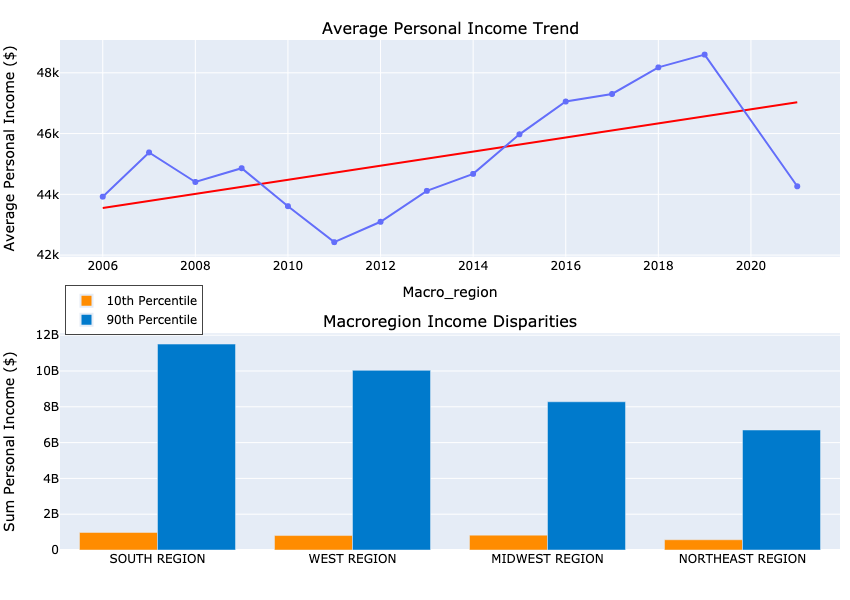

In [13]:
dfFinal['MacroPercentile10'] = dfFinal.groupby(['Macro_region'])['INCTOT'].transform(lambda x: x.quantile(0.1))
dfFinal['MacroPercentile90'] = dfFinal.groupby(['Macro_region'])['INCTOT'].transform(lambda x: x.quantile(0.9))

# Calculate mean, min, max income for each year
dfg = (
    dfFinal.groupby('YEAR')['INCTOT'].agg(['mean', 'min', 'idxmin', 'max', 'idxmax']).reset_index()
    .merge(dfFinal[['REGION', 'Macro_region']], left_on='idxmin', right_index=True)
    .merge(dfFinal[['REGION', 'Macro_region']], left_on='idxmax', right_index=True, suffixes=('_min', '_max'))
)

# Create subplots
fig4 = make_subplots(
    rows=2,
    cols=1,
    vertical_spacing=0.15,
    subplot_titles=['Average Personal Income Trend', 'Macroregion Income Disparities'],
    y_title=''
)

# Scatter and line charts for Personal Income Trend
trace = (px.scatter(dfg, x='YEAR', y='mean', trendline='ols', trendline_color_override='red')
    .add_trace(px.line(dfg, x='YEAR', y='mean').data[0])
    .update_traces(
        hovertemplate='<b>%{x}</b><br><i>Avg Income: <b>%{y}</b></i><br>%{text}',
        text=[f"Min Income: <b>{d['min']}</b>, REGION: {d['REGION_min'][:10]}, Max Income: <b>{d['max']}</b>, REGION: {d['REGION_max']}" for _, d in dfg.iterrows()],
        hoverlabel_bgcolor='black',
        hoverlabel_font_color='white'
    )
).data

fig4.add_trace(trace[0], row=1, col=1)
fig4.add_trace(trace[1], row=1, col=1)
fig4.add_trace(trace[2], row=1, col=1)

# Combine the 10th and 90th percentile data for plotting
combined_data = dfFinal.groupby('Macro_region')[['MacroPercentile10', 'MacroPercentile90']].sum().reset_index()

# Sort the data based on 90th percentile income in descending order
combined_data_sorted = combined_data.sort_values(by='MacroPercentile90', ascending=False)

# Bar chart for Income Distribution (10th and 90th Percentiles) for ALL Macro_regions
fig4.add_trace(
    go.Bar(x=combined_data_sorted['Macro_region'], y=combined_data_sorted['MacroPercentile10'],
           hovertemplate='Macro_region: %{x}<br>Sum Income: $%{y:.2f}', marker_color='darkorange',
           name='10th Percentile'), row=2, col=1
)

fig4.add_trace(
    go.Bar(x=combined_data_sorted['Macro_region'], y=combined_data_sorted['MacroPercentile90'],
           hovertemplate='Macro_region: %{x}<br>Sum Income: $%{y:.2f}', marker_color='#007ACC',
           name='90th Percentile'), row=2, col=1
)

fig4.update_layout(
    height=600,width = 850,
    margin=dict(r=10, t=40, b=50, l=60),
    coloraxis_autocolorscale=False,
    coloraxis_colorscale=['#007ACC', 'lightblue', 'yellow', 'orange', 'darkorange', 'red'],
    coloraxis_colorbar_title='Sum Personal Income ($)',
    xaxis=dict(title='Macro_region'),
    yaxis=dict(title='Average Personal Income ($)'), 
    font=dict(color='black'),
    showlegend=True,
    legend=dict(x=0.007, y=0.47,borderwidth=1, itemsizing='constant'),
)

fig4.update_yaxes(title='Sum Personal Income ($)', row=2, col=1)

fig4.show()


In summary, the top 100 earners hold a significant share of income compared to the bottom 5000 earners, while the 90th percentile in personal and family income almost doubles the gap between the 50th and 10th percentiles. From 2006 to 2021, the top 10% accumulated more wealth while the less fortunate fell behind, emphasizing the need for policies to address income inequality. In exploring the intricacies of economic inequality, it's also important to acknowledge race's significant role. This influence spans wealth disparities, employment opportunities, and property ownership.

## Deciphering Racial Economic Disparities

### Family Income by Ethnicity
The United States grapples with significant disparities in income and wealth across racial and ethnic groups, where Black and Hispanic/Latino households earn just over half of what White households make on average. These disparities are influenced by multifaceted factors, encompassing historical disadvantages, systemic biases, and limited access to education and employment opportunities. Visualizing the widening wealth gap through the provided graph over recent decades is a striking representation of this unequal distribution of wealth. 

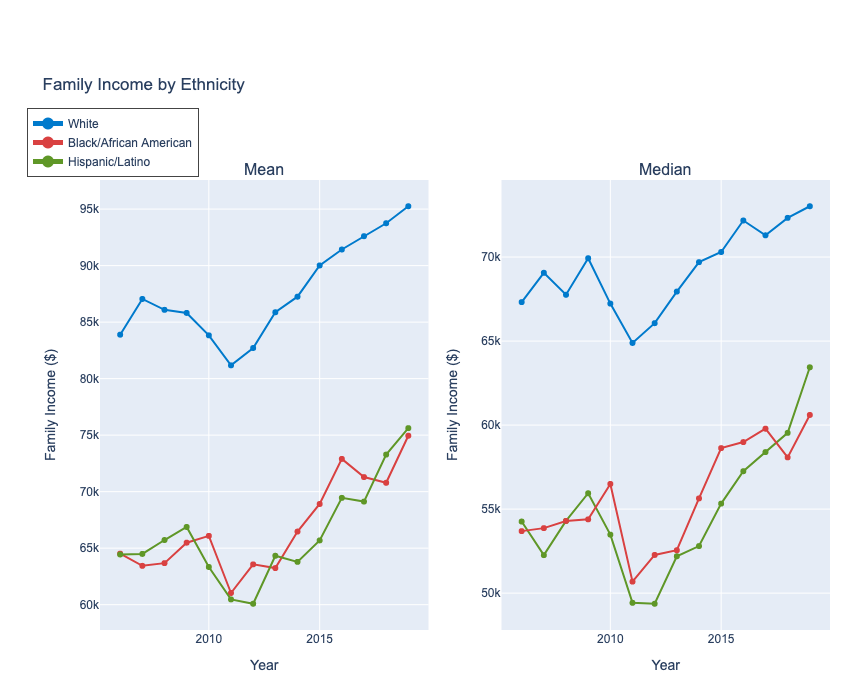

In [15]:
red_color = "#d94141"
white = dfFinal.query("RACHSING == 'White'")
whiteInc = white.groupby("YEAR", as_index=False)['FTOTINC'].mean()
black = dfFinal.query("RACHSING == 'Black/African American'")
blackInc = black.groupby("YEAR", as_index=False)['FTOTINC'].mean()
asian = dfFinal.query("RACHSING == 'Asian/Pacific Islander'").groupby("YEAR", as_index=False)['FTOTINC'].mean()
indian = dfFinal.query("RACHSING == 'American Indian/Alaska Native'").groupby("YEAR", as_index=False)['FTOTINC'].mean()
Hispanic = dfFinal.query("RACHSING == 'Hispanic/Latino'").groupby("YEAR", as_index=False)['FTOTINC'].mean()

data = [asian, indian]
non_white1 = pd.concat(data)

non_white = non_white1.groupby("YEAR", as_index=False)['FTOTINC'].mean()

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Mean", "Median"))

# Add average traces
fig.add_trace(go.Scatter(
    x=whiteInc['YEAR'],
    y=whiteInc['FTOTINC'],
    marker=dict(
        color="#007ACC",
    ), name="White", showlegend=True,
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=blackInc['YEAR'],
    y=blackInc['FTOTINC'],
    marker=dict(
        color="#d94141"
    ), name="Black/African American", showlegend=True
))

fig.add_trace(go.Scatter(
    x=Hispanic['YEAR'],
    y=Hispanic['FTOTINC'],
    marker=dict(
        color="#5f9727"
    ), name="Hispanic/Latino", showlegend=True
))

# Add median traces
whiteM = dfFinal.query("RACHSING == 'White'").groupby("YEAR", as_index=False)['FTOTINC'].median()
blackM = dfFinal.query("RACHSING == 'Black/African American'").groupby("YEAR", as_index=False)['FTOTINC'].median()
asianM = dfFinal.query("RACHSING == 'Asian/Pacific Islander'").groupby("YEAR", as_index=False)['FTOTINC'].median()
indianM = dfFinal.query("RACHSING == 'American Indian/Alaska Native'").groupby("YEAR", as_index=False)['FTOTINC'].median()
HispanicM = dfFinal.query("RACHSING == 'Hispanic/Latino'").groupby("YEAR", as_index=False)['FTOTINC'].median()

fig.add_trace(go.Scatter(
    x=HispanicM['YEAR'],
    y=HispanicM['FTOTINC'],
    marker=dict(
        color="#5f9727"
    ), name="Hispanic/Latino", showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=blackM['YEAR'],
    y=blackM['FTOTINC'],
    marker=dict(
        color=red_color
    ), name="Black/African American", showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=whiteM['YEAR'],
    y=whiteM['FTOTINC'],
    marker=dict(
        color="#007ACC"
    ), name="White", showlegend=False
), row=1, col=2)

# Update layout and style
fig.update_layout(
    height=700,width = 850,
    title_text="Family Income by Ethnicity",
    showlegend=True,
    margin=dict(l=100, r=20, t=180, b=70),
    font=dict(family='Arial, sans-serif', size=12),
    legend=dict(x=-0.1, y=1.16, orientation='v',borderwidth=1, itemsizing='constant'), 
)

fig.update_yaxes(title='Family Income ($)')
fig.update_xaxes(title='Year')

fig.show()

### Unemployment Rate Comparison: Non-White vs. White Americans
The chart highlights the unemployment rate for Black Americans, nearly double that of Whites, with Hispanics slightly higher. These disparities contribute to unequal wealth distribution. However, a positive note emerges: the unemployment gap slowly narrows over time, suggesting progress towards equitable opportunities. Addressing systemic employment inequalities is critical to reducing wealth gaps. Fostering inclusive job markets and policies can create a more balanced economic landscape.


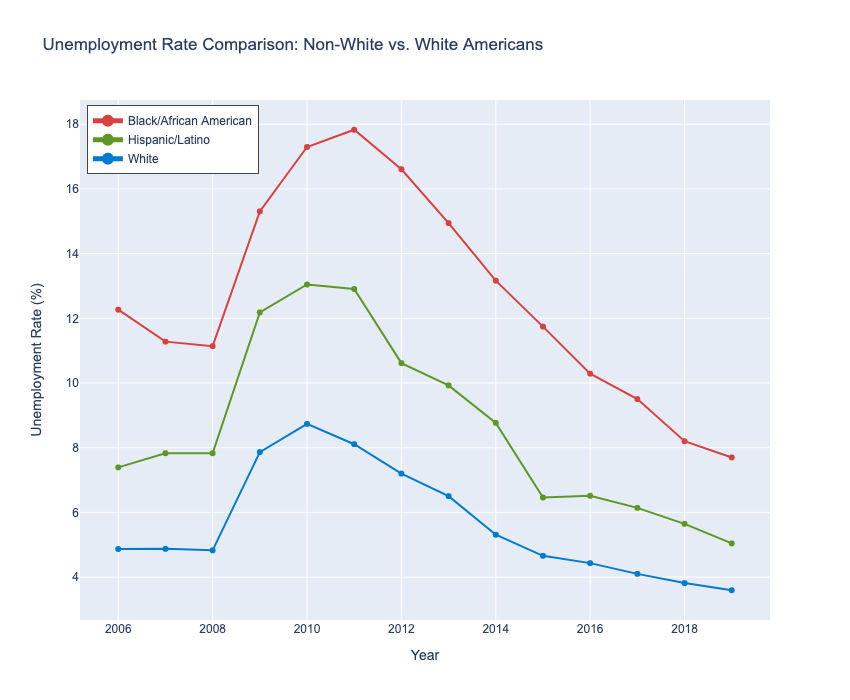

In [16]:
# Create pivot table
pivot_table = pd.pivot_table(df, index=['YEAR', 'RACHSING'], columns='EMPSTAT', aggfunc='size', fill_value=0)
pivot_table['Unemployment Rate'] = (pivot_table[2] / (pivot_table[1] + pivot_table[2])) * 100

# Filter out 'Asian/Pacific Islander' and 'American Indian/Alaska Native' categories
pivot_table_reset = pivot_table.reset_index()
pivot_table_reset = pivot_table_reset[
    (pivot_table_reset['RACHSING'] != 'Asian/Pacific Islander') &
    (pivot_table_reset['RACHSING'] != 'American Indian/Alaska Native')
]

custom_colors = {'White': '#007ACC', 'Black/African American': '#d94141', 'Hispanic/Latino': '#5f9727'}
    
# Create the line chart with animation timeline
fig = px.line(
    pivot_table_reset,
    x='YEAR',
    y='Unemployment Rate',
    color='RACHSING',
    title='Unemployment Rate Comparison: Non-White vs. White Americans',
    labels={'Unemployment Rate': 'Unemployment Rate (%)'},
    markers=True, 
    line_shape='linear', 
    color_discrete_map=custom_colors
)

# Update layout and style
fig.update_layout(
    height = 700,width=850,
    font=dict(family='Arial, sans-serif', size=12),
    legend=dict(x=0.01, y=0.99,title='',borderwidth=1, itemsizing='constant'),
)
fig.update_xaxes(title='Year')

fig.show()

### Population and Income Share in the U.S.

The provided code comprehensively analyses the population and income share dynamics among different racial groups in the United States. The resulting line chart illustrates the trends in population and income shares for Whites, Blacks, and Hispanics over time. Despite a 5% decline in population and income shares among White individuals over the past decade, their income share consistently exceeds their population share, accounting for 72% of the population share in 2021 and 77% of cumulative income. In contrast, the Black and Hispanic populations are growing, yet their income shares fall short, hovering at slightly over half of their population shares.  For instance, Hispanics constitute 12% of the population but only account for 8% of the national income, while Black individuals comprise 7% of the population but only contribute 5% to the overall revenue. This disparity suggests unequal distribution of economic opportunities, with Whites holding a larger income share relative to their population. Notably, the White population is the sole racial group with an income share exceeding their population share.

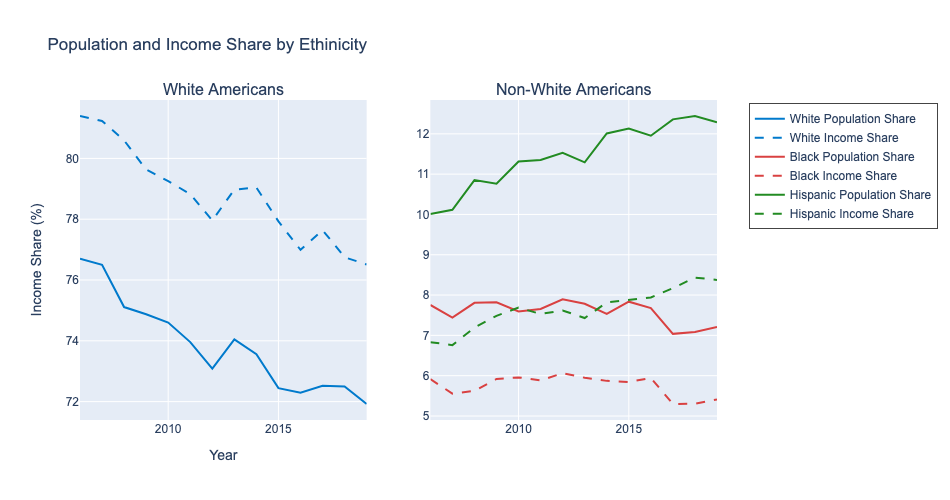

In [17]:
total_population = dfFinal.groupby('YEAR')['RACHSING'].count().reset_index()
black_population = dfFinal[dfFinal['RACHSING'] == 'Black/African American'].groupby('YEAR')['RACHSING'].count().reset_index()
black_income = dfFinal[dfFinal['RACHSING'] == 'Black/African American'].groupby('YEAR')['INCTOT'].sum().reset_index()

black_population['population_share'] = (black_population['RACHSING'] / total_population['RACHSING']) * 100
black_income['income_share'] = (black_income['INCTOT'] / dfFinal.groupby('YEAR')['INCTOT'].sum().reset_index()['INCTOT']) * 100

hispanic_population = dfFinal[dfFinal['RACHSING'] == 'Hispanic/Latino'].groupby('YEAR')['RACHSING'].count().reset_index()
hispanic_population['hispanic_population_share'] = (hispanic_population['RACHSING'] / total_population['RACHSING']) * 100
hispanic_income = dfFinal[dfFinal['RACHSING'] == 'Hispanic/Latino'].groupby('YEAR')['INCTOT'].sum().reset_index()
hispanic_income['hispanic_income_share'] = (hispanic_income['INCTOT'] / dfFinal.groupby('YEAR')['INCTOT'].sum().reset_index()['INCTOT']) * 100

white_population = dfFinal[dfFinal['RACHSING'] == 'White'].groupby('YEAR')['RACHSING'].count().reset_index()
white_income = dfFinal[dfFinal['RACHSING'] == 'White'].groupby('YEAR')['INCTOT'].sum().reset_index()
white_population['white_population_share'] = (white_population['RACHSING'] / total_population['RACHSING']) * 100
total_income = dfFinal.groupby('YEAR')['INCTOT'].sum().reset_index()
white_income['white_income_share'] = (white_income['INCTOT'] / total_income['INCTOT']) * 100



fig = make_subplots(rows=1, cols=2, subplot_titles=('White Americans', 'Non-White Americans'))

# Add lines for White population and income share
fig.add_trace(go.Scatter(x=white_population['YEAR'], y=white_population['white_population_share'], name='White Population Share', mode='lines', line=dict(color="#007ACC")), row=1, col=1)
fig.add_trace(go.Scatter(x=white_income['YEAR'], y=white_income['white_income_share'], name='White Income Share', mode='lines', line=dict(color="#007ACC", dash='dash')), row=1, col=1)

# Add lines for Black and Hispanic populations and income share
fig.add_trace(go.Scatter(x=black_population['YEAR'], y=black_population['population_share'], mode='lines', name='Black Population Share', line=dict(color=red_color)), row=1, col=2)
fig.add_trace(go.Scatter(x=black_income['YEAR'], y=black_income['income_share'], mode='lines', name='Black Income Share', line=dict(color=red_color, dash='dash')), row=1, col=2)
fig.add_trace(go.Scatter(x=hispanic_population['YEAR'], y=hispanic_population['hispanic_population_share'], mode='lines', name='Hispanic Population Share', line=dict(color=green_color)), row=1, col=2)
fig.add_trace(go.Scatter(x=hispanic_income['YEAR'], y=hispanic_income['hispanic_income_share'], mode='lines', name='Hispanic Income Share', line=dict(color=green_color, dash='dash')), row=1, col=2)

# Update layout and style
fig.update_layout(
    height = 500,width=950,
    font=dict(family='Arial, sans-serif', size=12),
    legend=dict(x=1.05, y=0.99, orientation='v',borderwidth=1), 
    title='Population and Income Share by Ethinicity ',
    xaxis_title='Year',
    yaxis_title='Income Share (%)'
)

fig.show()

### Bottom 10% of Income Group

The presented line chart reveals the evolving racial composition within the bottom 10% income group over a specified timeframe. Focusing on three major racial categories – White, Black/African American, and Hispanic/Latino – the chart showcases their respective percentages within the income group. The data underscores that the percentage of Black/African American and Hispanic/Latino individuals in the bottom 10% of the income category is substantially higher than that of Whites, with both racial groups showing almost double the percentage. This visual insight emphasizes the notable presence of non-White individuals within the bottom 10% of income earners, shedding light on the pronounced economic disparities across racial lines.

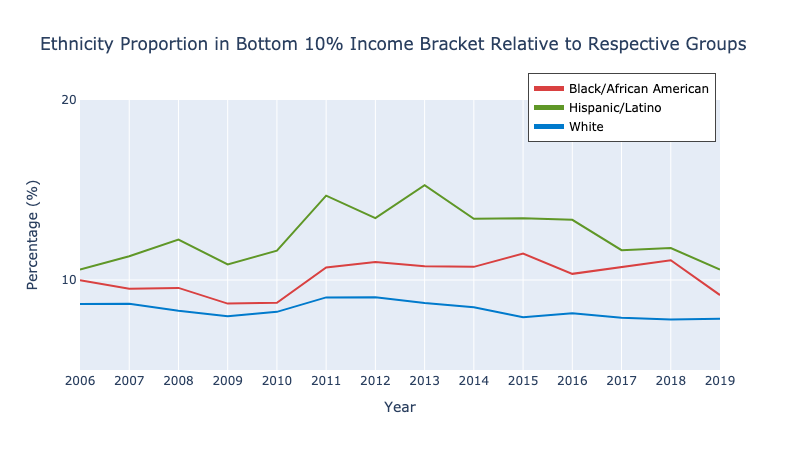

In [18]:
bottom10 = dfFinal[dfFinal['Income Category'] == 'Bottom 10%']
bottom10 = bottom10[bottom10['RACHSING'].isin(['White', 'Black/African American', 'Hispanic/Latino'])]

# Calculate necessary aggregates
total_income_by_race = dfFinal.groupby(['YEAR', 'RACHSING'])['INCTOT'].sum()
total_earners_by_race = dfFinal.groupby(['YEAR', 'RACHSING'])['INCTOT'].count()

pivot_table = pd.pivot_table(bottom10, index=['YEAR', 'RACHSING'], values='INCTOT', aggfunc='count', fill_value=0)
pivot_table['Percentage'] = (pivot_table['INCTOT'] / total_earners_by_race) * 100
pivot_table_reset = pivot_table.reset_index()

custom_colors = {'White': '#007ACC', 'Black/African American': '#d94141', 'Hispanic/Latino': '#5f9727'}

fig = px.line(
    pivot_table_reset,
    x='YEAR',
    y='Percentage',
    color='RACHSING', 
    labels={'Percentage': 'Percentage (%)'},
    title='Ethnicity Proportion in Bottom 10% Income Bracket Relative to Respective Groups', 
    line_dash_sequence=['solid', 'dash', 'dot'], 
    color_discrete_map=custom_colors,
    width=800,  
    height=500, 
    range_y=[5, 20],
    hover_name='RACHSING',  
    hover_data={'Percentage': ':.2f'},
)

# Customize the legend
fig.update_layout(
    height=450,width=800,
    legend_title_text='Race',  
    legend=dict(borderwidth=1, itemsizing='constant',
        x=0.7, 
        y=1.1,  title='',
        font=dict(color='black') 
    ),
)

# Customize the x-axis
fig.update_xaxes(
    title='Year',  
    tickmode='linear',  
    dtick=1,  
    showline=True,  
    linewidth=1,  
    showgrid=True,  
)

# Customize the y-axis
fig.update_yaxes(
    title='Percentage (%)', 
    tickmode='linear', 
    dtick=10,  
    showline=True,  
    linewidth=1,
    showgrid=True,  
)

fig.show()

### Housing Ownership Disparities
The line chart illustrates significant disparities in homeownership rates among White, Black/African American, and Hispanic/Latino. Over the years, white homeownership remains nearly double that of Black/African American and Hispanic/Latino homeownership. This discrepancy reflects income differences and broader systemic factors affecting housing access. The graph underscores the challenges faced by Black and Hispanic communities, showing that fewer than half of these groups own homes, in contrast to around 80% of Whites. Over a decade, homeownership rates have seen minimal improvement among Hispanic and Black populations, resulting in a persistent gap of approximately 20%. This visualization highlights the profound impact of historical and structural factors on homeownership disparities.


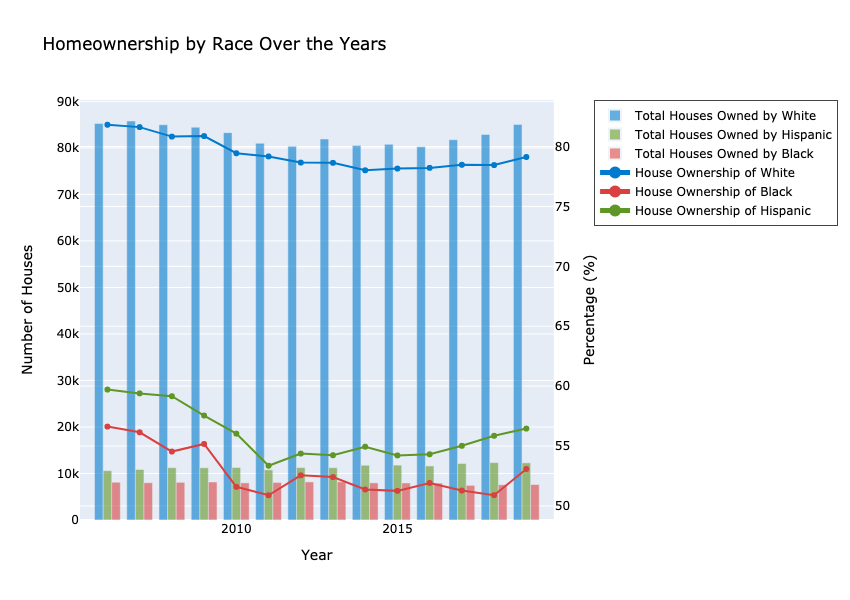

In [19]:
home = df.drop(df[(df['OWNERSHP'] == 0)].index)
race_counts = dfFinal.drop(dfFinal[(dfFinal['OWNERSHP'] == 0)].index)
custom_colors = {'White': '#007ACC', 'Black/African American': '#d94141', 'Hispanic/Latino': '#5f9727'}

# Calculate race counts
race_count = race_counts.groupby("RACHSING", as_index=False)['OWNERSHP'].value_counts()

# Query data for Black/African American households
blackHouse = home.query("RACHSING == 'Black/African American'").groupby("YEAR", as_index=False)['OWNERSHP'].value_counts()

# Replace numerical race codes with actual race names
home["RACHSING"].replace({
    1: "White",
    2: "Black/African American",
    3: "American Indian/Alaska Native",
    4: "Asian/Pacific Islander",
    5: "Hispanic/Latino"
}, inplace=True)

# Calculate race counts by year
race_c = home.groupby('YEAR', as_index=False)['RACHSING'].value_counts()

# Calculate percentage of people owning a house by race and year
grouped_df = home.query("OWNERSHP == 1").groupby('YEAR', as_index=False)['RACHSING'].value_counts()
grouped_df1 = grouped_df.drop(grouped_df[(grouped_df['RACHSING'] == "American Indian/Alaska Native") | (grouped_df['RACHSING'] == "Asian/Pacific Islander")].index)
grouped_df1['Percentage'] = (grouped_df1['count'] / race_c['count']) * 100

filtered_houses_by_race = grouped_df[~grouped_df['RACHSING'].isin(['American Indian/Alaska Native', 'Asian/Pacific Islander'])]

# Create the line chart
bar_chart_houses = go.Figure()

for race in filtered_houses_by_race['RACHSING'].unique():
    data_by_race = filtered_houses_by_race[filtered_houses_by_race['RACHSING'] == race]
    if race == 'White':
        trace_name = 'Total Houses Owned by White'
    elif race == 'Hispanic/Latino':
        trace_name = 'Total Houses Owned by Hispanic'
    elif race == 'Black/African American':
        trace_name = 'Total Houses Owned by Black'
    else:
        trace_name = race  
    bar_chart_houses.add_trace(go.Bar(
        x=data_by_race['YEAR'],
        y=data_by_race['count'],
        name=trace_name,
        opacity=0.6, marker_color=custom_colors.get(race, 'gray')
    ))

bar_chart_houses.update_layout(
    barmode='group', 
    xaxis_title='Year',
    yaxis_title='Number of Houses',
    title='Number of Houses Owned by Race Over the Years',
    legend=dict(borderwidth=1, itemsizing='constant',
        x=0.5,
        y=1.5,
        font=dict(color='black'),
    ),
    xaxis=dict(
        showline=True,
        linewidth=1,
        showgrid=True
    ),
    yaxis=dict(
        showline=True,
        linewidth=1,
        showgrid=True,
    )
)

line_chart_percentage = go.Figure()

for race, color in custom_colors.items():
    data_by_race = grouped_df1[grouped_df1['RACHSING'] == race]
    line_chart_percentage.add_trace(go.Scatter(
        x=data_by_race['YEAR'],
        y=data_by_race['Percentage'],
        name=race,
        mode='lines+markers',
        line=dict(color=color),  
        marker=dict(color=color)
    ))
    
line_chart_percentage.update_layout(
    legend=dict(borderwidth=1, itemsizing='constant',
        x=0.5,
        y=1.5,
        font=dict(color='black')
    ),
    xaxis=dict(
        title='Year',
        tickmode='linear',
        dtick=1,
        showline=True,
        linewidth=1,
        showgrid=True,
    ),
    yaxis=dict(
        title='Percentage (%)',
        tickmode='linear',
        dtick=10,
        showline=True,
        linewidth=1,
        showgrid=True
    )
)


# Combine both line charts into a single graph with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])
for trace in bar_chart_houses['data']:
    fig.add_trace(trace, secondary_y=False)
for trace in line_chart_percentage['data']:
    if trace.name == 'White':
        trace.name = 'House Ownership of White'
    elif trace.name == 'Hispanic/Latino':
        trace.name = 'House Ownership of Hispanic'
    elif trace.name == 'Black/African American':
        trace.name = 'House Ownership of Black'
    fig.add_trace(trace, secondary_y=True)  

fig.update_layout(
    title='Homeownership by Race Over the Years',
    font=dict(color='black'),
    height=600,width=850,legend=dict(borderwidth=1, itemsizing='constant')
)
fig.update_traces(patch={'legendgroup': ''})


fig.update_yaxes(title_text='Number of Houses', secondary_y=False)
fig.update_yaxes(title_text='Percentage (%)', secondary_y=True)
fig.update_xaxes(title_text='Year')

fig.show()

The United States grapples with significant income and wealth disparities across racial groups, notably with Black and Hispanic/Latino households earning about half of what White households do. These disparities stem possibly from historical injustices, systemic biases, and unequal access to education and employment. The data demonstrates an expanding wealth disparity, with elevated unemployment rates among Black and Hispanic Americans playing a role in exacerbating this inequality. Persistent gaps in homeownership rates also underscore the ongoing challenges faced by these communities. Besides racial wealth disparities, gender significantly influences economic inequality, manifesting in income gaps, career disparities, and gender-specific industry inequities.

## Navigating Gender Economic Disparities

Men and Women in Income Categories
The animated bar charts provide insights into gender differences between income and family income categories. In the individual income context, men consistently dominate the highest income tiers (top 1% and 0.1%), with women's representation at around 10-20%. Conversely, women constitute most in lower income segments (bottom 10%, 1%, and 0.1%). Interestingly, the gender gap is narrower in family income distribution, possibly indicating that women with lower personal income benefit from higher-earning spouses, lessening the career-family trade-off. This trend is less evident for men. Women's representation in the top income brackets almost doubles when considering family total income. This underscores the intricate connection between career choices, family dynamics, and gender disparities.

[Gender Composition by Personal Income](https://htmlpreview.github.io/?https://github.com/Lixx05/Economic.Inequality/blob/main/Gender_Composition_by_Personal_Income.html)

[Gender Composition by Family Income](https://htmlpreview.github.io/?https://github.com/Lixx05/Economic.Inequality/blob/main/Gender_Composition_by_Family_Income.html)

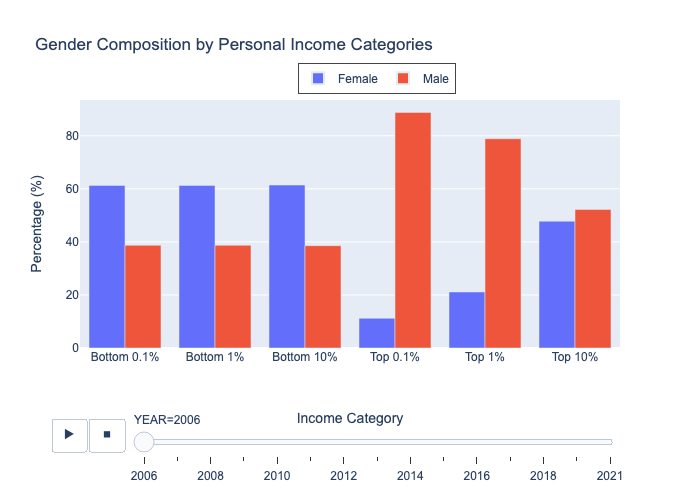

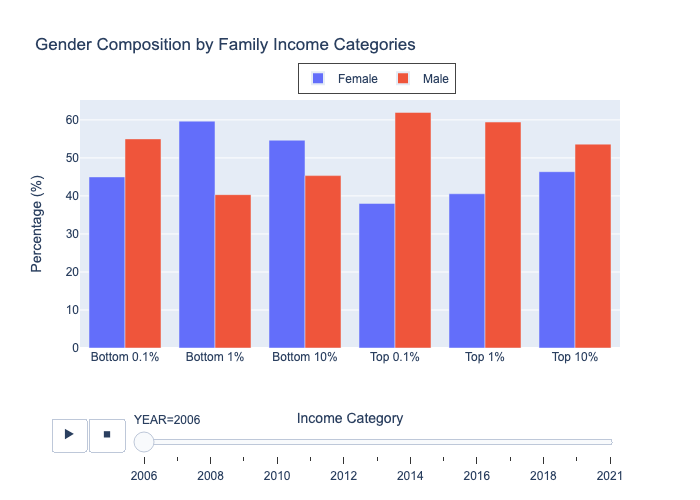

In [21]:
grouped_data3 = dfFinal.groupby(['Income Category', 'YEAR', 'SEX'])['SEX'].count().unstack()
grouped_data3 = grouped_data3.div(grouped_data3.sum(axis=1), axis=0) * 100

grouped_data3 = grouped_data3.stack().reset_index(name='Percentage')
fig2 = px.bar(
    grouped_data3,
    x='Income Category',
    y='Percentage',
    color='SEX',
    animation_frame='YEAR',
    title='Gender Composition by Personal Income Categories',
    labels={'Income Category': 'Income Category', 'Percentage': 'Percentage'},
    barmode='group'
)

# Update layout and style
fig2.update_layout(
    legend=dict(borderwidth=1, itemsizing='constant',
        title=None,
        orientation='h',
        yanchor='top',
        y=1.15,
        xanchor='center',
        x=0.55
    ),
    font=dict(
        family='Arial, sans-serif',
        size=12
    ),
    yaxis=dict(
        title='Percentage (%)',
        showgrid=True
    ),
    xaxis=dict(
        title='Income Category',
        showgrid=False,
        title_standoff=50,
    )
)


fig2.show()


percentiles = [0.001, 0.01, 0.1, 0.9, 0.99, 0.999]
quantiles = dfFinal['FTOTINC'].quantile(percentiles)

categories = ['Bottom 0.1%', 'Bottom 1%', 'Bottom 10%', 'Top 10%', 'Top 1%', 'Top 0.1%']

dfFinal['Income Category'] = dfFinal['FTOTINC'].apply(lambda x: next((
    categories[i] for i, q in enumerate(quantiles) if x <= q), categories[-1])
)

# Group by 'Income Category' and 'YEAR', and calculate the sum of percentages for each sex within the group
grouped_data = dfFinal.groupby(['Income Category', 'YEAR', 'SEX'])['SEX'].count().unstack()
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

grouped_data = grouped_data.stack().reset_index(name='Percentage')

fig1 = px.bar(
    grouped_data,
    x='Income Category',
    y='Percentage',
    color='SEX',
    animation_frame='YEAR',
    title='Gender Composition by Family Income Categories',
    labels={'Income Category': 'Income Category', 'Percentage': 'Percentage'},
    barmode='group'
)


fig1.update_layout(
    legend=dict(borderwidth=1, itemsizing='constant',
        title=None,
        orientation='h',
        yanchor='top',
        y=1.15,
        xanchor='center',
        x=0.55
    ),
    font=dict(
        family='Arial, sans-serif',
        size=12
    ),
    yaxis=dict(
        title='Percentage (%)',
        showgrid=True
    ),
    xaxis=dict(
        title='Income Category',
        showgrid=False,
        title_standoff=50,
    )
)

fig1.show()

### Income by Number of Children and Gender

Women with no children tend to have higher median and mean incomes than those with children, reflecting potential career trade-offs. Interestingly, men's median and mean incomes remain relatively steady across varying numbers of children. However, the sudden increase in income for men with eight children might indicate a sample size issue or other underlying factors. This anomaly could be due to data collection errors, statistical variation, or specific circumstances affecting a small subgroup. The visualization suggests that for women, balancing career and family responsibilities might contribute to income disparities related to family size. In contrast, men's incomes appear less influenced by the number of children. 


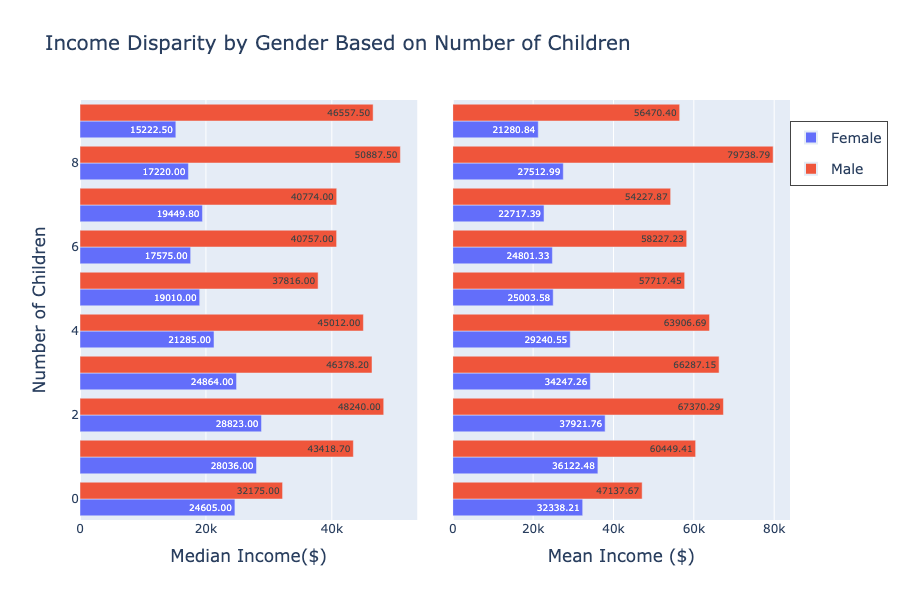

In [22]:
grouped_data = dfFinal.groupby(['SEX', 'NCHILD']).agg({'INCTOT': ['median', 'mean']}).reset_index()
grouped_data.columns = ['GENDER', 'NCHILD', 'Median Income', 'Mean Income']

fig = sp.make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.05)

# Create bar chart for median income
median_fig = px.bar(
    grouped_data,
    x='Median Income',
    y='NCHILD',
    color='GENDER',
    orientation='h',
    text='Median Income',
    title='Median Income by Number of Children and Gender',
    hover_data=['Median Income'] 
)

for trace in median_fig.data:
    trace.hoverinfo = 'x+y+text' 
    trace.texttemplate = '%{text:.2f}' 
    fig.add_trace(trace, row=1, col=1)

# Create bar chart for mean income
mean_fig = px.bar(
    grouped_data,
    x='Mean Income',
    y='NCHILD',
    color='GENDER',
    orientation='h',
    text='Mean Income',
    title='Mean Income by Number of Children and Gender',
    hover_data=['Mean Income']
)

for trace in mean_fig.data:
    trace.hoverinfo = 'x+y+text' 
    trace.texttemplate = '%{text:.2f}'  
    fig.add_trace(trace, row=1, col=2)

# Update layout and style
fig.update_layout(
    title_text='Income Disparity by Gender Based on Number of Children',
    yaxis=dict(title='Number of Children', tickfont=dict(size=12)),
    xaxis1=dict(title='Median Income($)', tickfont=dict(size=12)),
    xaxis2=dict(title='Mean Income ($)', tickfont=dict(size=12)),
    font=dict(size=14),
    legend=dict(x=1, y=0.95,borderwidth=1, itemsizing='constant'), 
    barmode='group',
    bargap=0.2,
    height=600,
    width=900
)

fig.update_traces(showlegend=True, row=1, col=1)
fig.update_traces(showlegend=False, row=1, col=2)

fig.show()

### Social Security and Retirement Income 
The chart demonstrate that males earn higher incomes than females, including in Social Security and Retirement Income. Notably, the gender gap is more pronounced in Retirement Income, where some women receive only half of men's retirement income. This trend may be attributed to various factors, including gender wage gaps, career interruptions for caregiving responsibilities, and structural inequalities in pension systems. 

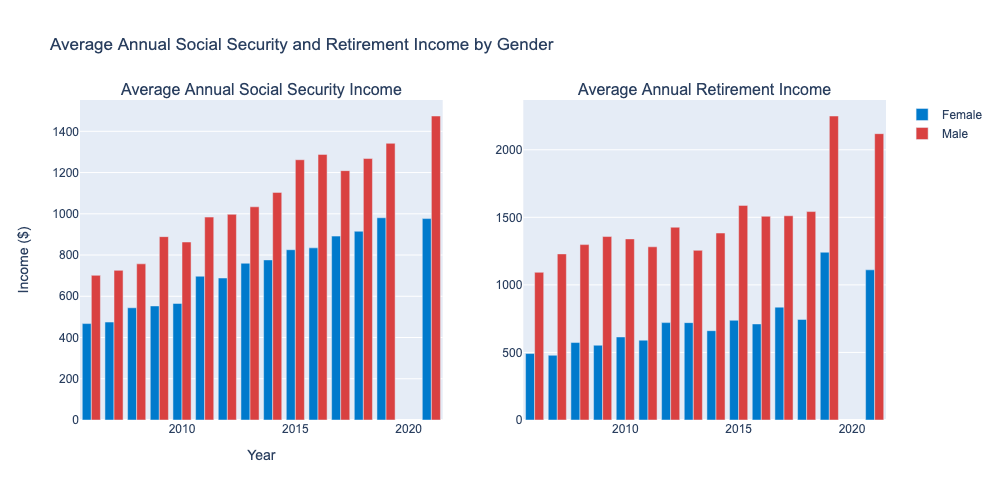

In [23]:
dfFilteredSS = dfFinal[dfFinal['INCSS'] != 99999]

# Filter the DataFrame for valid retirement income values
dfFilteredRetirement = dfFinal[dfFinal['INCRETIR'] != 999999]

# Group by YEAR and SEX, calculate the mean of INCSS for each group
grouped_sscss = dfFilteredSS.groupby(['YEAR', 'SEX'])['INCSS'].mean().unstack()

# Group by YEAR and SEX, calculate the mean of INCRETIR for each group
grouped_retirement = dfFilteredRetirement.groupby(['YEAR', 'SEX'])['INCRETIR'].mean().unstack()

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Average Annual Social Security Income", "Average Annual Retirement Income"))

# Add traces for Average Social Security Income
for col in grouped_sscss.columns:
    color = "#007ACC" if col == 'Female' else red_color
    fig.add_trace(go.Bar(x=grouped_sscss.index, y=grouped_sscss[col], name=col, marker=dict(color=color)), row=1, col=1)

# Add traces for Average Retirement Income
for col in grouped_retirement.columns:
    color = "#007ACC" if col == 'Female' else red_color
    fig.add_trace(go.Bar(x=grouped_retirement.index, y=grouped_retirement[col], name=col, marker=dict(color=color)), row=1, col=2)

# Update layout for the entire figure
fig.update_layout(
    title_text='Average Annual Social Security and Retirement Income by Gender',
    xaxis_title='Year',
    yaxis_title='Income ($)',
    font=dict(
        family='Arial, sans-serif',
        size=12
    ),
    barmode='group',
    height=500,
    width=1000
)

fig.update_traces(showlegend=True, row=1, col=1)
fig.update_traces(showlegend=False, row=1, col=2)

fig.show()

### Women's Median Earnings Share
This graph highlights a notable trend in economic disparities across racial groups regarding the share of women's earnings compared to men's. Black and Hispanic women consistently earn higher percentages of White women's earnings share, surpassing the overall average. This underscores a complex interplay of race and gender in economic dynamics. The observation suggests that Black and Hispanic women proportionally contribute more to household income, possibly due to unique financial circumstances. 

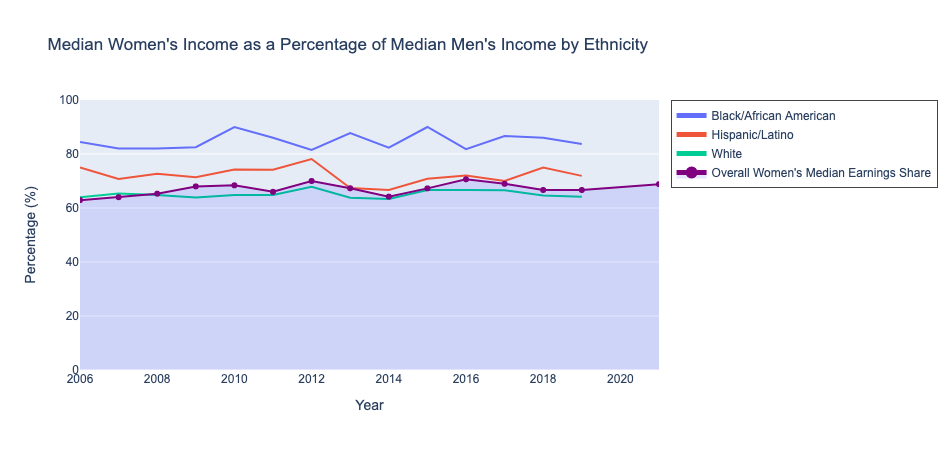

In [24]:
excluded_races = ["American Indian/Alaska Native", "Asian/Pacific Islander"]

# Filter the DataFrame for excluded races
dfFinal_filtered = dfFinal[~dfFinal['RACHSING'].isin(excluded_races)]

# Filter the DataFrame for females only
dfFullTimeFemale = dfFinal_filtered[dfFinal_filtered['SEX'] == 'Female']

# Group by YEAR, RACHSING, and SEX and calculate median earnings
dfMedian_race = dfFinal_filtered.groupby(['YEAR', 'RACHSING', 'SEX'])['INCTOT'].median().unstack()

# Calculate the share of women's earnings by race
dfMedian_race['Share'] = dfMedian_race['Female'] / dfMedian_race['Male'] * 100

# Group by YEAR and SEX and calculate median earnings
dfMedian_overall = dfFinal_filtered.groupby(['YEAR', 'SEX'])['INCTOT'].median().unstack()

# Calculate the share of women's earnings overall
dfMedian_overall['Share'] = dfMedian_overall['Female'] / dfMedian_overall['Male'] * 100

fig = px.line(
    dfMedian_race.reset_index(),
    x='YEAR',
    y='Share',
    color='RACHSING',
    labels={'Share': "Percentage Share (%)"},
    title="Median Women's Income as a Percentage of Median Men's Income by Ethnicity",
    line_shape='linear',
)

# Add the overall women's median earnings share as a filled area
fig.add_trace(
    go.Scatter(
        x=dfMedian_overall.index,  
        y=dfMedian_overall['Share'],
        fill='tozeroy',
        fillcolor='rgba(0, 0, 255, 0.1)',
        line=dict(color='purple'),
        name="Overall Women's Median Earnings Share"
    )
)

fig.update_layout(height= 450, width=950,
    xaxis_title='Year',
    yaxis_title='Percentage (%)',
    font=dict(
        family='Arial, sans-serif',
        size=12
    ),
    xaxis=dict(showgrid=False),
    yaxis=dict(
        showgrid=True,
        range=[0, 100]), legend=dict(title='',borderwidth=1, itemsizing='constant'
    )
)

fig.show()

### Industry-Specific Gender Inequality

This split violin plot presents a comprehensive analysis of income distribution among men and women across various industries. Notably, while there is a consistent trend in income distribution across macroregions, the magnitude of gender economic inequality varies significantly depending on the industry. In educational services, women's income distribution closely mirrors men's, with only a slight discrepancy of approximately 10k between the mean and median income figures. However, this discrepancy sharply escalates within the finance and healthcare sectors, where men's mean and median incomes are nearly double those of women. Furthermore, the split violin plot underscores the prevalence of men earning over 100k annually, which is notably more pronounced within the finance and healthcare industries. These findings highlight the profound impact of gender inequality within industries on overall economic disparities, as women earn less than their male counterparts in the exact professional domains.


[Industry-Specific Gender Inequality](https://htmlpreview.github.io/?https://github.com/Lixx05/Economic.Inequality/blob/main/Industry_Specific.html)

In [25]:
industry_mapping = {
    7970: 'Health Care and Social Assistance',
    7980: 'Health Care and Social Assistance',
    7990: 'Health Care and Social Assistance',
    8070: 'Health Care and Social Assistance',
    8080: 'Health Care and Social Assistance',
    8090: 'Health Care and Social Assistance',
    8170: 'Health Care and Social Assistance',
    8180: 'Health Care and Social Assistance',
    8190: 'Health Care and Social Assistance',
    8270: 'Health Care and Social Assistance',
    8290: 'Health Care and Social Assistance',
    8370: 'Health Care and Social Assistance',
    8380: 'Health Care and Social Assistance',
    8390: 'Health Care and Social Assistance',
    8470: 'Health Care and Social Assistance',
    6870: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6880: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6890: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6970: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6990: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7070: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7080: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7170: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7180: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7190: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7860: 'Educational Services',
    7870: 'Educational Services',
    7880: 'Educational Services',
    7890: 'Educational Services'
}

# Group individual values together within each section
grouped_mapping = {
    'Health Care and Social Assistance': 'Health Care and Social Assistance',
    'Finance and Insurance, and Real Estate and Rental and Leasing': 'Finance and Insurance, and Real Estate and Rental and Leasing',
    'Educational Services': 'Educational Services'
}

dfFinal['IND'] = dfFinal['IND'].replace(industry_mapping)

# Define the grouped mapping
grouped_mapping = {
    'Health Care and Social Assistance': 'Health Care and Social Assistance',
    'Finance and Insurance, and Real Estate and Rental and Leasing': 'Finance and Insurance, and Real Estate and Rental and Leasing',
    'Educational Services': 'Educational Services'
}

dfFinal['IND'] = dfFinal['IND'].replace(grouped_mapping)

In [26]:
industry_mapping = {
    7970: 'Health Care and Social Assistance',
    7980: 'Health Care and Social Assistance',
    7990: 'Health Care and Social Assistance',
    8070: 'Health Care and Social Assistance',
    8080: 'Health Care and Social Assistance',
    8090: 'Health Care and Social Assistance',
    8170: 'Health Care and Social Assistance',
    8180: 'Health Care and Social Assistance',
    8190: 'Health Care and Social Assistance',
    8270: 'Health Care and Social Assistance',
    8290: 'Health Care and Social Assistance',
    8370: 'Health Care and Social Assistance',
    8380: 'Health Care and Social Assistance',
    8390: 'Health Care and Social Assistance',
    8470: 'Health Care and Social Assistance',
    6870: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6880: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6890: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6970: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    6990: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7070: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7080: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7170: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7180: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7190: 'Finance and Insurance, and Real Estate and Rental and Leasing',
    7860: 'Educational Services',
    7870: 'Educational Services',
    7880: 'Educational Services',
    7890: 'Educational Services'
}

# Group individual values together within each section
grouped_mapping = {
    'Health Care and Social Assistance': 'Health Care and Social Assistance',
    'Finance and Insurance, and Real Estate and Rental and Leasing': 'Finance and Insurance, and Real Estate and Rental and Leasing',
    'Educational Services': 'Educational Services'
}

dfFinal['IND'] = dfFinal['IND'].replace(industry_mapping)

# Define the grouped mapping
grouped_mapping = {
    'Health Care and Social Assistance': 'Health Care and Social Assistance',
    'Finance and Insurance, and Real Estate and Rental and Leasing': 'Finance and Insurance, and Real Estate and Rental and Leasing',
    'Educational Services': 'Educational Services'
}

dfFinal['IND'] = dfFinal['IND'].replace(grouped_mapping)

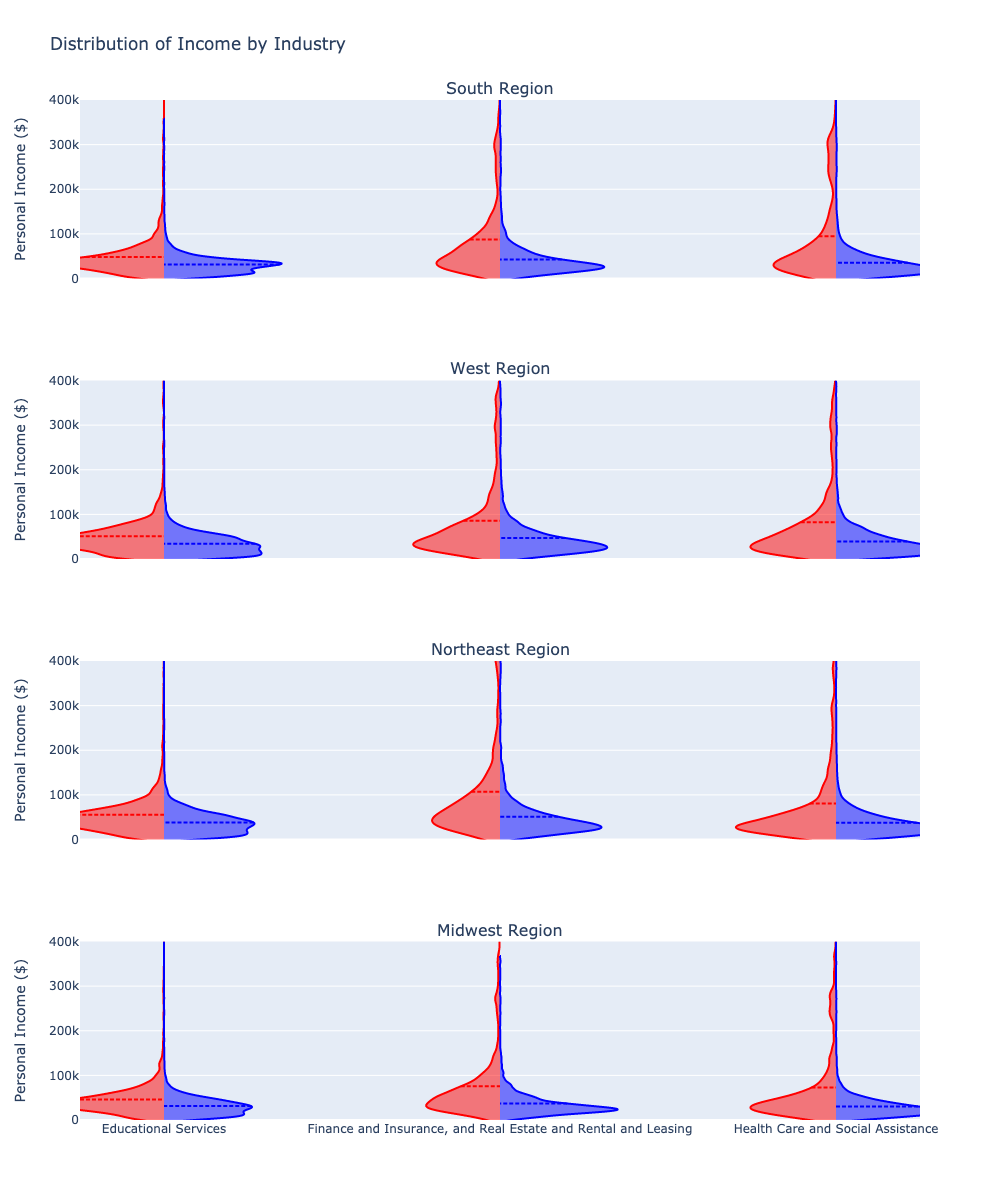

In [27]:
selected_inds = ['Educational Services', 'Finance and Insurance, and Real Estate and Rental and Leasing', 'Health Care and Social Assistance']

male_data = dfFinal[(dfFinal['SEX'] == 'Male') & (dfFinal['IND'].isin(selected_inds))]
female_data = dfFinal[(dfFinal['SEX'] == 'Female') & (dfFinal['IND'].isin(selected_inds))]

macro_regions = dfFinal['Macro_region'].unique()

subplot_height = 300 

subplot_titles=["South Region", "West Region", "Northeast Region", "Midwest Region"]

fig3 = make_subplots(rows=len(macro_regions), cols=1, shared_xaxes=True, vertical_spacing=0.1,
                   subplot_titles=subplot_titles, row_heights=[subplot_height] * len(macro_regions))

for i, macro_region in enumerate(macro_regions):
    male_region_data = male_data[male_data['Macro_region'] == macro_region]
    female_region_data = female_data[female_data['Macro_region'] == macro_region]
    
    male_trace = go.Violin(x=male_region_data['IND'],
                           y=male_region_data['INCTOT'],
                           legendgroup=f'Male_{macro_region}', scalegroup=f'Male_{macro_region}',
                           name='Male', side='negative', line_color='red', points=False)
    
    female_trace = go.Violin(x=female_region_data['IND'],
                             y=female_region_data['INCTOT'],
                             legendgroup=f'Female_{macro_region}', scalegroup=f'Female_{macro_region}',
                             name='Female', side='positive', line_color='blue', points=False)
    
    fig3.add_trace(male_trace, row=i+1, col=1)
    fig3.add_trace(female_trace, row=i+1, col=1)

fig3.update_traces(meanline_visible=True)
fig3.update_layout(width=1000,violingap=0, violinmode='overlay')

for i in range(len(macro_regions)):
    fig3.update_yaxes(title_text='Personal Income ($)', row=i+1, col=1,range=[0, 400000])

fig3.update_layout(showlegend = False, title_text="Distribution of Income by Industry", height=len(macro_regions) * subplot_height)

fig3.show()

In summary, the data highlights gender disparities in income distribution, influenced by factors like family dynamics, race, and industry. Men tend to dominate higher income tiers, but the gap narrows in family income, possibly due to spousal support. Racial disparities are evident, with Black and Hispanic women often earning more proportionally. Gender gaps persist in retirement income, and some industries like finance and healthcare exhibit substantial inequalities.

While these findings provide valuable insights, they also raise several open questions and areas for future research. These may include investigating the underlying causes of the persistent gender wage gap within specific industries and understanding how societal norms and expectations influence income distribution. Furthermore, conducting intersectional analyses that consider multiple dimensions of identity, such as gender and race, can provide a more comprehensive understanding of income disparities and inform targeted interventions for achieving economic equity. While the gender financial gap is closely intertwined with societal expectations, examining educational attainment can provide valuable insights to explore the impact of education on various aspects of economic well-being.


## Analyzing Educational Attainment's Impact on Economic Disparities

### Wealth Gaps by Educational Attainment
The line plot depicts a clear relationship between educational attainment and median family wealth, indicating that higher education corresponds to increased wealth accumulation. The graph also reveals a narrowing wealth gap among various educational groups over time, particularly prominent for those with advanced degrees. This reduction in the wealth gap might be attributed to specialized skills, strategic financial decisions, and policy efforts. Overall, the visualization underscores the positive impact of education on wealth accumulation and the encouraging trend of decreasing wealth disparities among different educational groups.

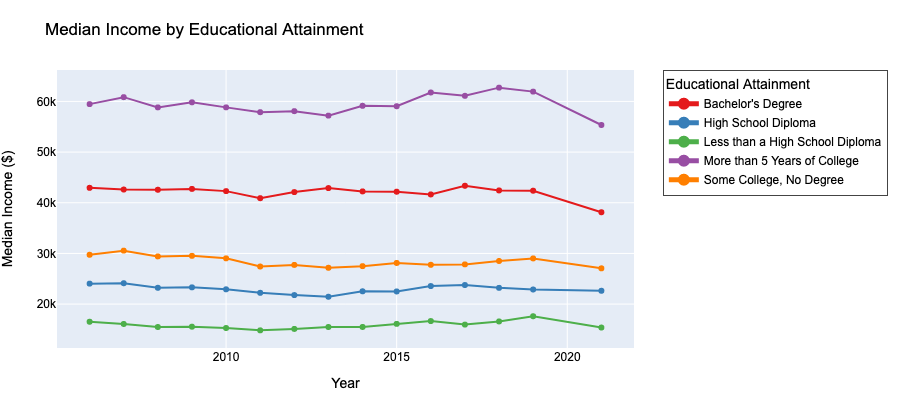

In [29]:
df_stats2 = dfFinal.groupby(['EDUC', 'YEAR'])['INCTOT'].median().reset_index()

colors = px.colors.qualitative.Set1 
fig = px.line(df_stats2, x='YEAR', y='INCTOT', color='EDUC', color_discrete_sequence=colors,
              labels={'YEAR': 'Year', 'INCTOT': 'Median Income', 'EDUC': 'Educational Attainment'},
              title="Median Income by Educational Attainment",
              markers=True, 
              line_shape='linear'
             )

fig.update_layout(width=900,height=400,
    xaxis_title="Year",
    yaxis_title="Median Income ($)",
    font=dict(family='Arial, sans-serif', size=12, color='black'),  
    legend_title="Educational Attainment",
    showlegend=True,
    legend=dict(x=1.05, y=1, borderwidth=1, itemsizing='constant', orientation='v'),  

    margin=dict(l=50, r=20, t=70, b=50)
)


fig.show()

### Earnings and Unemployment Rate

The chart shows that higher education is linked to higher earnings and lower unemployment rates. This highlights the advantages of advanced qualifications and their role in enhancing employability and economic stability. The consistent decline in unemployment rates with increasing education emphasizes the value of continuous learning and skill development. This reinforces the idea that investing in education yields financial and professional benefits, contributing to individual and societal growth.


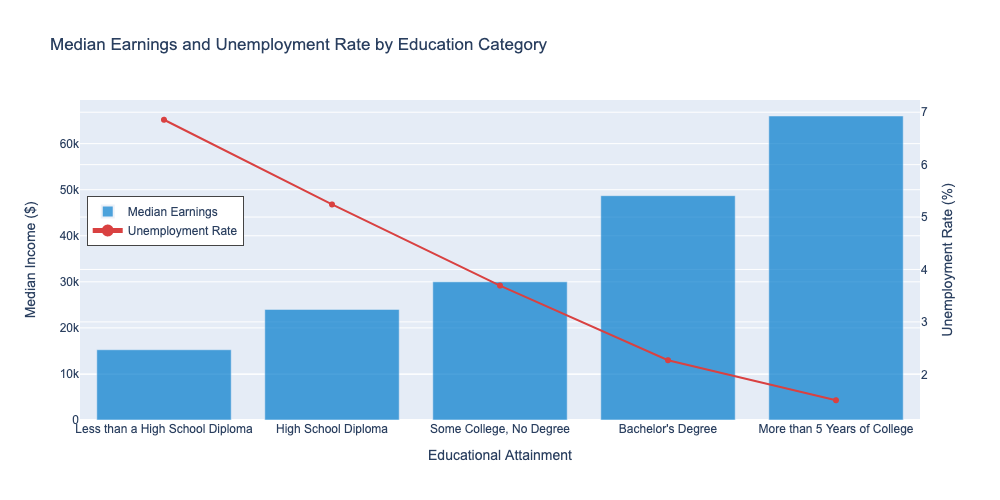

In [30]:
# Filter out NaN values in EDUC and exclude negative or extremely high INCWAGE values
df_filtered = df.dropna(subset=['EDUC'])
df_filtered = df_filtered[(df_filtered['INCWAGE'] > 0) & (df_filtered['INCWAGE'] <= 999997)]

# Create an ordered categorical data type for 'EDUC' column
edu_categories_order = [
    "Less than a High School Diploma",
    "High School Diploma",
    "Some College, No Degree",
    "Bachelor's Degree",
    "More than 5 Years of College"
]
edu_categories_dtype = pd.CategoricalDtype(categories=edu_categories_order, ordered=True)
df_filtered['EDUC'] = df_filtered['EDUC'].astype(edu_categories_dtype)

# Calculate median earnings for each education category
df_median_wage = df_filtered.groupby('EDUC')['INCWAGE'].median().reset_index()

# Calculate unemployment rate for each education category
df_unemployed = df_filtered[df_filtered['EMPSTAT'].isin([1, 2])].groupby('EDUC')['EMPSTAT'].apply(lambda x: (x == 2).sum() / len(x) * 100).reset_index()

# Merge the two dataframes
df_combined = df_median_wage.merge(df_unemployed, on='EDUC')

# Create a combined bar and line chart
fig = go.Figure()

# Bar chart for median earnings
fig.add_trace(go.Bar(x=df_combined['EDUC'], y=df_combined['INCWAGE'],
                     name='Median Earnings', opacity=0.7, marker_color="#007ACC"))

# Line chart for unemployment rate
fig.add_trace(go.Scatter(x=df_combined['EDUC'], y=df_combined['EMPSTAT'],
                         name='Unemployment Rate', yaxis='y2',
                         line=dict(color=red_color, width=2)))

# Define layout
fig.update_layout(height=500,width = 1000,
    title='Median Earnings and Unemployment Rate by Education Category',
    xaxis_title='Educational Attainment',
    yaxis_title='Median Income ($)',
    yaxis2=dict(title='Unemployment Rate (%)', overlaying='y', side='right'),
    font=dict(
        family='Arial, sans-serif',
        size=12,
    ),
    legend=dict(x=0.008, y=0.7,borderwidth=1, itemsizing='constant'),
    showlegend=True
)

fig.show()

### Median Income by Age and Educational Attainment

This analysis visualizes the relationship between age, education,  and median income. The line chart displays how income changes across age groups and education levels. Younger individuals show minor educational income differences, but disparities become more pronounced with age. Those with "5+ Years of College" consistently achieve the highest median income. Academic levels like "Bachelor's Degree" and "More than 5 Years of College" maintain higher incomes, particularly early in careers. Income generally increases with age until a certain point, suggesting career growth. The visualization highlights education's role in income disparities and emphasizes its advantages for earnings, especially as careers progress. It also acknowledges the impact of various factors on income trajectories over time.

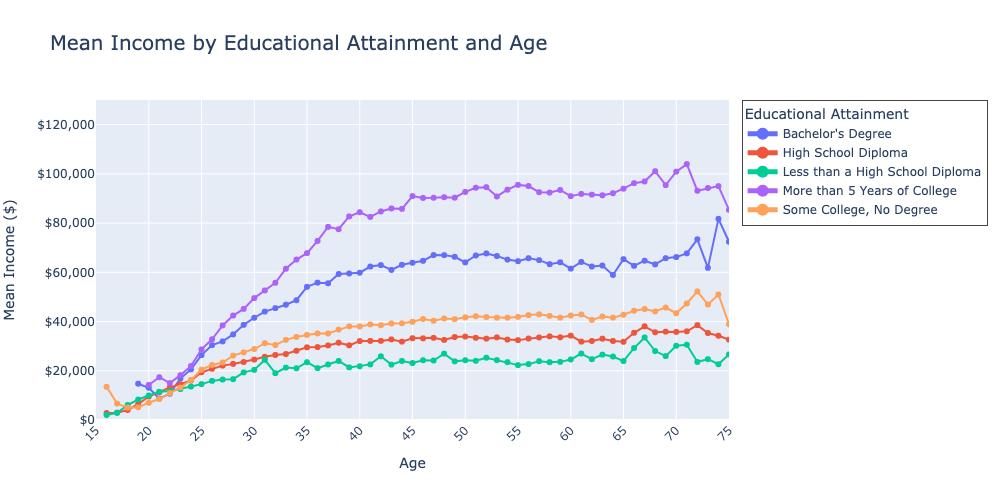

In [31]:
df_mean_income = dfFinal.groupby(['EDUC', 'AGE'])['INCTOT'].mean().reset_index()

# Create the Plotly line chart
fig = px.line(df_mean_income, x='AGE', y='INCTOT', color='EDUC', 
              title='Mean Income by Educational Attainment and Age',
              labels={'AGE': 'Age', 'INCTOT': 'Mean Income ($)', 'EDUC': 'Educational Attainment'})

# Customize the legend
fig.update_layout(
    legend_title_text='Educational Attainment',
    legend=dict(
        title_font_size=14,
        font=dict(size=12)
    )
)

# Set the x-axis range up to 75 years
fig.update_xaxes(range=[15, 75])
fig.update_yaxes(range=[0, 130000])

# Customize the colors
fig.update_traces(mode='lines+markers')  # Show both lines and markers
fig.update_traces(marker=dict(size=8), selector=dict(mode='markers'))

# Customize the layout
fig.update_layout(height=500,width = 1000,
    title_font_size=20,
    xaxis=dict(
        title_font_size=14,
        tickfont=dict(size=12),
        tickvals=list(range(15, 76, 5)),
        tickangle=-45
    ),
    yaxis=dict(
        title_font_size=14,
        tickfont=dict(size=12),
        tickformat='$,.0f'
    ), legend =dict(borderwidth=1, itemsizing='constant')
)

fig.show()

In summary, higher education is consistently associated with increased wealth accumulation, higher earnings, and lower unemployment rates, emphasizing the value of advanced qualifications in enhancing employability and financial stability. The increasing wealth gap among educational groups with age can be attributed to higher education levels offering enhanced career prospects and more informed investment decisions. In contrast, lower education levels may result in reduced financial resources and limited access to certain avenues for wealth accumulation. However, these findings also prompt important questions for future research,  such as the long-term effects of education on wealth and income disparities, the mechanisms through which education shapes financial outcomes, and the role of policies in reducing educational and income gaps. Further exploration of the intersections between education and other demographic factors can provide a deeper insight of economic disparities and inform strategies for promoting equitable economic growth.


## Conclusion

This notebook examines the effect of gender, race and educational attainment on economic inequality. Gender-based income gaps persist, with women earning less than their male counterparts. Additionally, racial disparities highlight a slower wealth accumulation within minority communities, and a higher level of education typically correlates with enhanced financial stability. However, it's important to note that the visualization's representativeness of the entire population is limited due to the constrained sample size.

Despite the graph-derived insights,  gender disparities may stem from cultural restrictions and societal norms. These cultural factors can be challenging to dissect through data alone fully. Similarly, systemic discrimination operates indirectly, accrues over time, and intertwines with multiple facets of life. When analyzing data, imperceptible biases, intricate causality, and qualitative elements present challenges. Regarding educational attainment, the entry barrier significantly influences wealth disparities. This barrier encompasses various aspects, such as access to quality education, financial resources, and balancing full-time study with part-time employment. 

These multifaceted dynamics require not only data analysis but also interdisciplinary research, qualitative insights, and an exploration of the multidimensional nature of inequality. The proposed topics highlighted here underscore the ongoing need for further investigation and inquiry into the intricate web of factors perpetuating societal economic disparities. In pursuing a more equitable and just future, these challenges must be met with dedication, empathy, and a commitment to comprehensive understanding and action.
